In [1]:
# This program is to form the data into pkl file
# Basic setting
# # import package
import h5py
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
# colors
import matplotlib.colors as colors
import matplotlib as mpl  # Add this line


rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255 # By Nick
# colors = np.array([[112,115,115],[137,209,201], [18,78,120], [242,187,5],[215,78,9],[255,16,7]])/255


In [2]:
PR = 50
v_file_path    = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/v/PR{PR}_500_20000day_6hourly_v.dat"
u_file_path    = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/u/PR{PR}_500_20000day_6hourly_u.dat"
p_file_path    = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/p/PR{PR}_500_20000day_6hourly_p.dat"
prec_file_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec.dat"
y = np.linspace(-90,90,64)

In [6]:
# Read v variable
# with h5py.File(v_file_path, 'r') as file:
#         v = np.asarray(file['v'][:, :, :, :])

# # # Read u variable
# with h5py.File(u_file_path, 'r') as file:
#         u = np.asarray(file['u'][:, :, :, :])

# # Read p variable
# with h5py.File(p_file_path, 'r') as file:
#         p = np.asarray(file['p'][:, :, :, :])

# prec_mean_array = np.zeros((6, 64))
# Read p variable
y = np.linspace(-90,90,64)
aa = 0
plt.figure(figsize=(8,6), dpi=300.)
for PR in [0, 10, 20, 30, 40, 50]:
    # prec_file_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec.dat"

    # with h5py.File(prec_file_path, 'r') as file:
    #         prec = np.asarray(file['prec'][:, :, :])
        
    # prec_mean = np.mean(prec, axis=(0,2)) 
    # prec_mean_array[aa] = prec_mean
    if PR ==0:
        plt.plot(y, prec_mean_array[aa] * 86400 * PR * 0.01 , label=f"L = Dry", color=colors[int(PR*0.1)])
    else:
        plt.plot(y, prec_mean_array[aa] * 86400 * PR * 0.01 , label=f"L = {0.01*PR}", color=colors[int(PR*0.1)])
    aa += 1
    
plt.legend(loc="best", prop={'size': 10},frameon=False, ncols=2)
plt.title("Precipitation [mm/day]", fontsize=14)
plt.xlabel("Latitude")
plt.show()
    

NameError: name 'prec_mean_array' is not defined

<Figure size 2400x1800 with 0 Axes>

In [10]:


# ==================== #
# main function
def main():
    # load data
    pr_list = np.array([0, 10, 20, 30, 40, 50]) # candidate to load

    # design coordinate
    lat = np.linspace(-90, 90, 64)
    lon = np.linspace(0, 360, 129)[:-1]
    time = np.linspace(0, 78000, 78000)
    # time = np.linspace(0, 78000/4-1, 78000)
    

    cond = np.where((lat>=-15)&(lat<=15))[0]

    print(cond)
    # # load data
    for pr in pr_list:
        with h5py.File(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{pr}/prec/PR{pr}_500_20000day_6hourly_prec_0_600hPa_sum.nc"
                       
                ) as f:
            prec_data = np.array(f["prec"][:, cond, :])
        
        # with nc.Dataset(f"/home/b11209013/2024_Research/PowerSpec_Dycore/data/prec_pr{pr}.nc", "w") as f:
        with nc.Dataset(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/PowerSpec_Dycore/data/pr{pr}/prec_pr{pr}_0_600hPa_sum.nc", "w") as f:
            
            
            lon_dim = f.createDimension("lon", 128)
            lat_dim = f.createDimension("lat", len(cond))
            time_dim = f.createDimension("time", 78000)

            lon_var = f.createVariable("lon", np.float64, ("lon",))
            lon_var[:] = lon

            lat_var = f.createVariable("lat", np.float64, ("lat",))
            lat_var[:] = lat[cond]

            time_var = f.createVariable("time", np.float64, ("time",))
            time_var[:] = time

            prec0 = f.createVariable("prec", np.float64, ("time", "lat", "lon"))
            prec0[:] = prec_data

        print(f"PR {pr} finished")

# ==================== #
# execution section
if __name__ == "__main__":
    main()


[27 28 29 30 31 32 33 34 35 36]
PR 0 finished
PR 10 finished
PR 20 finished
PR 30 finished
PR 40 finished
PR 50 finished


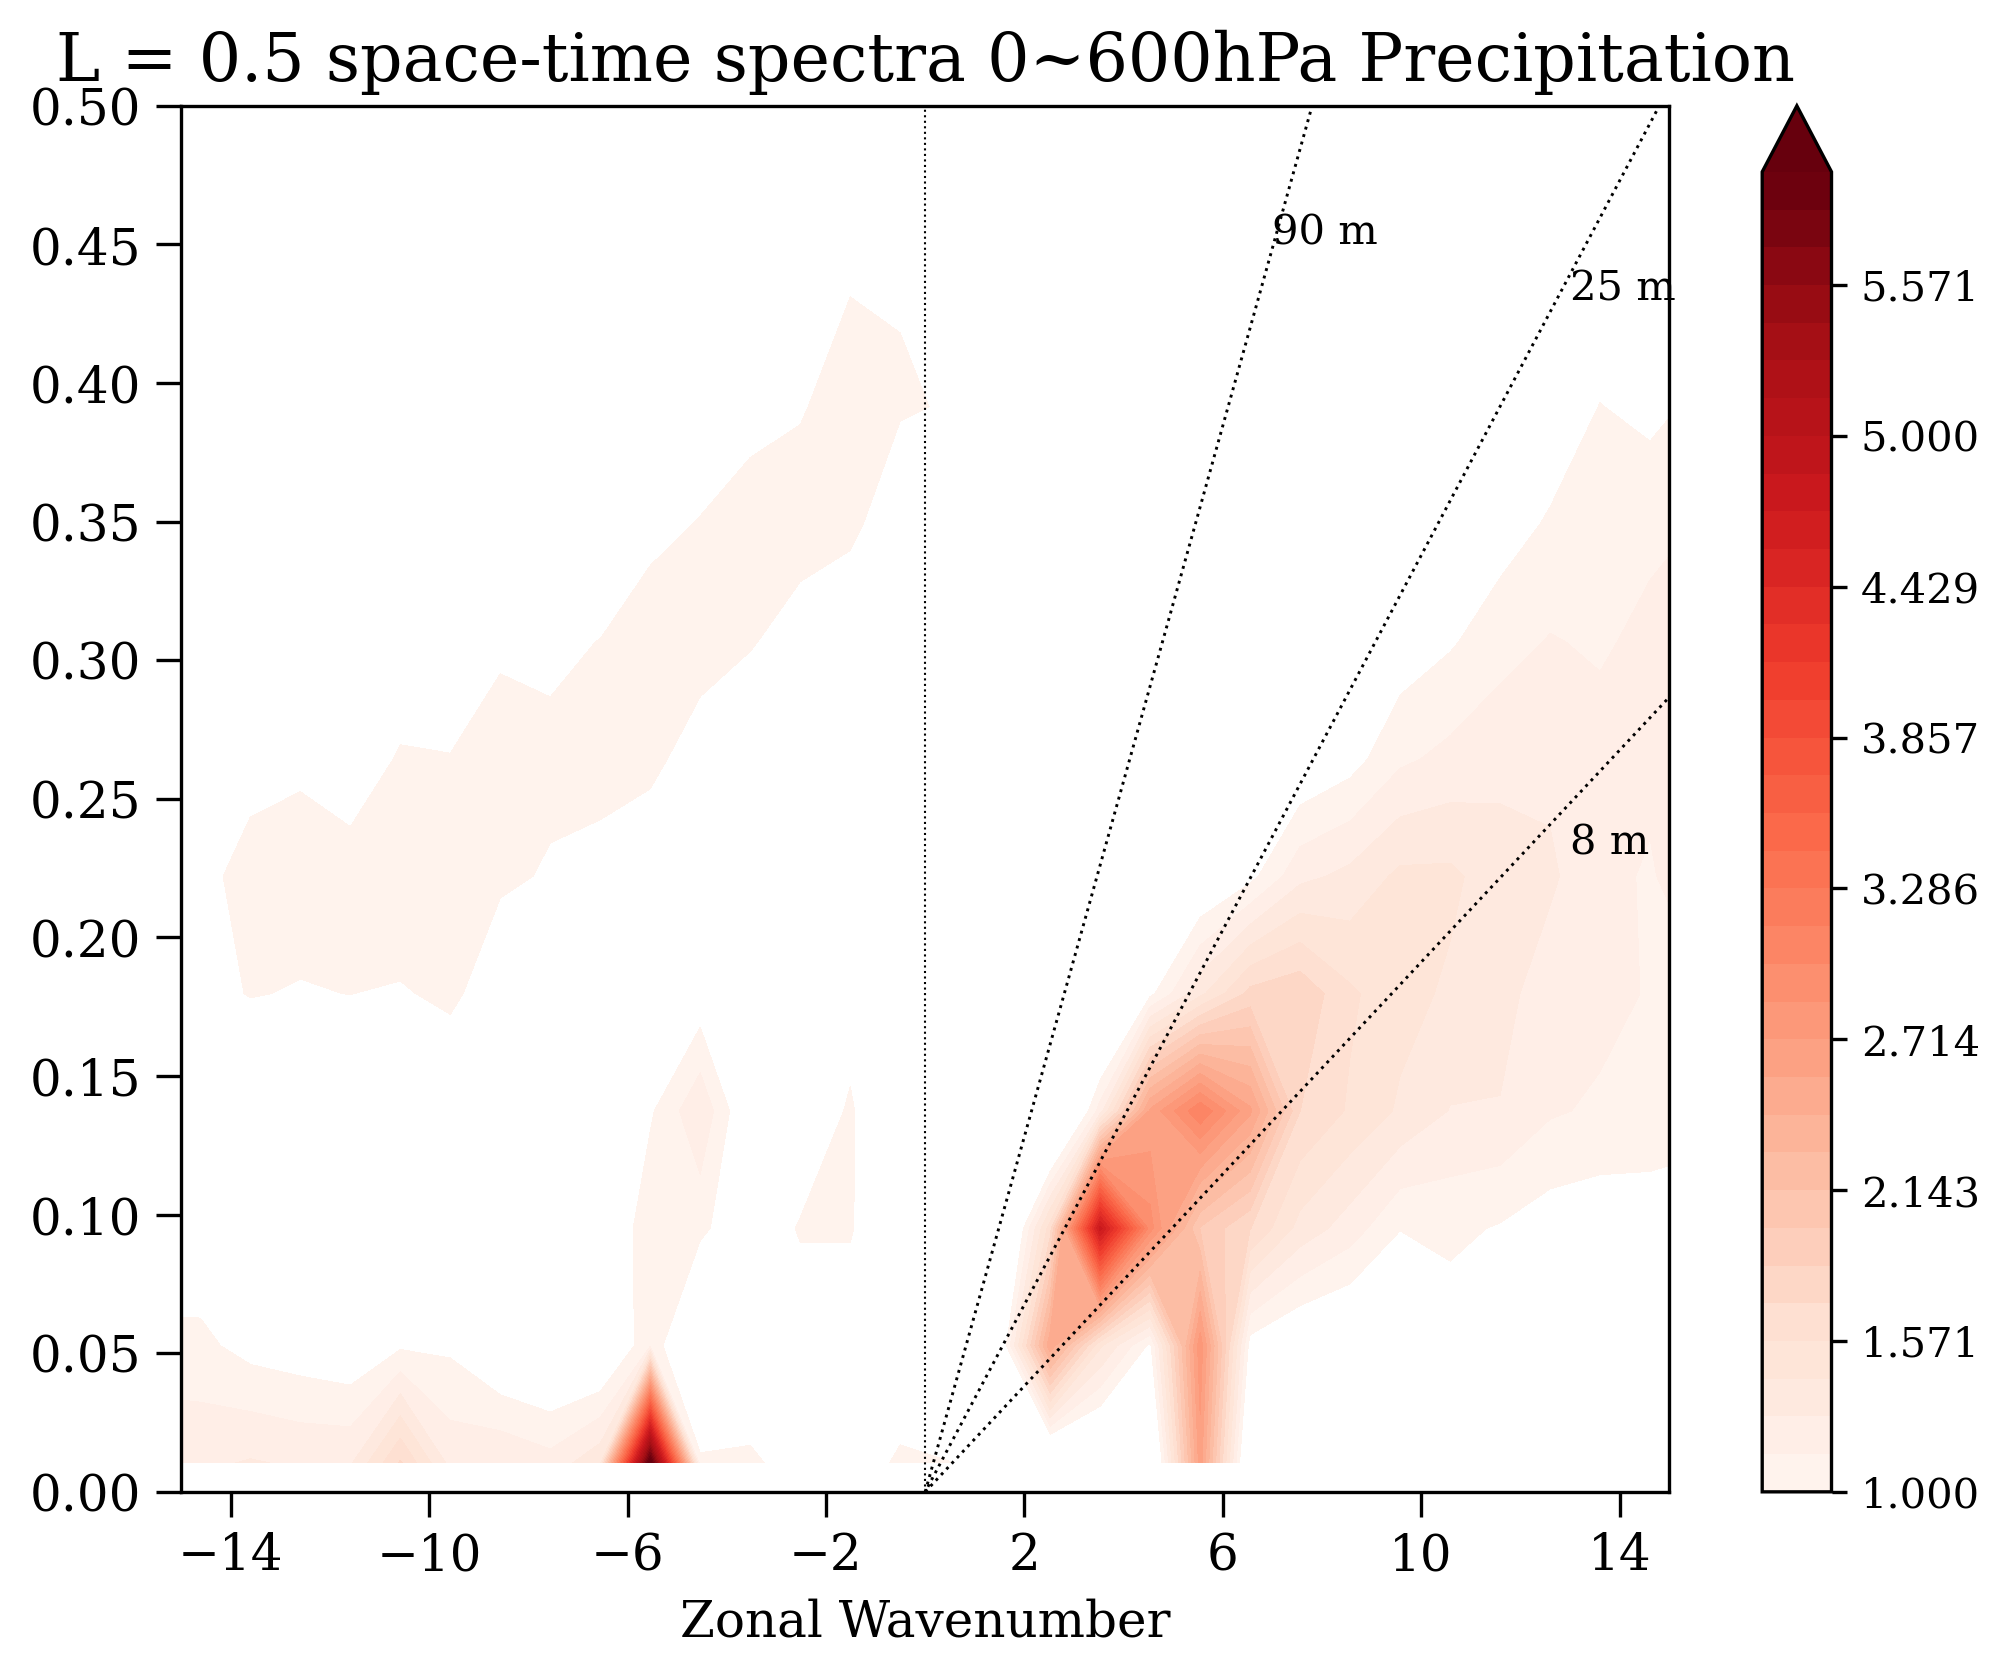

In [11]:
#######################################################################################
import sys
import h5py
import numpy as np
import netCDF4 as nc
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# sys.path.append("/home/b11209013/Package/")
sys.path.append("/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/PowerSpec_Dycore/Package/")
import Theory as th 

import DataProcess as dp
import SignalProcess as sp

plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["font.family"] = "serif"

# ================== #
# functions
# Gaussian filter
def background(sym, asy, cr=10):
    ave = (sym + asy) / 2

    low = dp.GaussianFilter(ave[:cr], 40)
    high = dp.GaussianFilter(ave[cr:], 10)

    space_filt = np.concatenate([low, high], axis=0).T

    bg = dp.GaussianFilter(space_filt, 10).T

    return bg

# ============================= #
def main(PR):
    # Load data
    lat = np.linspace(-90, 90, 64)

    cond = np.where((lat >= -15) & (lat <= 15))[0]
    lat = lat[cond]

    # Load precipitation data
    # with h5py.File(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec_0_600hPa_sum.dat") as f:
    with h5py.File(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec.dat") as f:
        
        prec = f["prec"][:, cond, :]
        # prec *= PR * 0.01

    prec = prec - prec.mean()  # Remove the mean

    # Apply Hanning window to reduce edge effects
    window = np.hanning(prec.shape[1])[:, None] * np.hanning(prec.shape[2])
    prec_windowed = prec * window

    # ============================== #
    
    # FFT with windowing
    prec_fft = np.array([
        np.fft.fftshift(np.fft.fft2(prec_windowed[:, i, :]))[:, ::-1]
        for i in range(len(lat))
    ])

    # ============================== #
    
    # Split data into segments
    split = np.array([prec[i * 36:i * 36 + 96] for i in range(2165)])

    # Format data for symmetry and asymmetry
    fmt = dp.Format(lat)
    
    sym_split = np.array([fmt.sym(split[i]) for i in range(split.shape[0])])
    asy_split = np.array([fmt.asy(split[i]) for i in range(split.shape[0])])

    # ============================== #
    
    # Power Spectrum
    ft = sp.Fourier()
    
    sym_ps = np.array([ft.PowerSpectrum(sym_split[i]) for i in range(2165)]).mean(axis=0)
    asy_ps = np.array([ft.PowerSpectrum(asy_split[i]) for i in range(2165)]).mean(axis=0)

    # =============================== #
    
    # Peak computation
    bg = background(sym_ps, asy_ps, 15)
    sym_peak = sym_ps / bg 

    # =============================== #
    
    # Plot Power Spectrum
    
    wn = np.linspace(-64, 64, 128)
    fr = np.linspace(1 / 96, 2, 48)
    
    wnm, frm = np.meshgrid(wn, fr)
 
    Kelvin8 = th.Wave(wn, 8)
    Kelvin25 = th.Wave(wn, 25)
    Kelvin90 = th.Wave(wn, 90)

    fig, ax = plt.subplots(1, figsize=(8,6), dpi=300.)
    cs = ax.contourf(
        wnm,
        frm,
        sym_peak,
        cmap="Reds",
        levels=np.linspace(1, 6, 36),
        extend="max",
    )
    ax.plot(
        wn, Kelvin8.Kelvin(), color="black", linestyle=":", linewidth=0.7
    )
    ax.plot(
        wn, Kelvin25.Kelvin(), color="black", linestyle=":", linewidth=0.7
    )
    ax.plot(
        wn, Kelvin90.Kelvin(), color="black", linestyle=":", linewidth=0.7
    )
    ax.text(7, 0.45, "90 m", fontsize=10)
    ax.text(13, 0.43, "25 m", fontsize=10)
    ax.text(13, 0.23, "8 m", fontsize=10)
    ax.axvline(0, color="black", linewidth=0.5, linestyle=":")
    ax.set_xticks(np.linspace(-14, 14, 8))
    ax.set_yticks(np.linspace(0, 0.5, 11))
    ax.set_xlim(-15, 15)
    ax.set_ylim(0, 1 / 2)
    ax.set_xlabel("Zonal Wavenumber")
    ax.set_title(f"L = 0.5 space-time spectra 0~600hPa Precipitation", fontsize=16)
    plt.colorbar(cs)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(direction='out', length=6)

    # plt.savefig(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/Fig4-1/L{PR}_Kelvin wave.png", bbox_inches='tight', dpi=600.)

    plt.show()
    

if __name__ == "__main__":
    PR = 50
    main(PR)


In [535]:
# This program is to reconstruct the signal of the signal of Kelvin waves
# Basic Settring 
# # import package
import sys
import h5py
import numpy as np

from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter 

from matplotlib import colors as cm
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm


sys.path.append("/home/b11209013/Package/")
import Theory as th

# ================== #
# functions
# # plot setting
def plot_setting():
    plt.rcParams["axes.titlesize"] = 14
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["xtick.labelsize"] = 10
    plt.rcParams["ytick.labelsize"] = 10
    plt.rcParams["font.family"] = "serif"

# ================== #
# main function
def main(PR):
    # load data
    path:str = f"/home/b11209013/2024_Research/PowerSpec_Dycore/data/pr{PR}/"

    # # range latitude
    lat = np.linspace(-90, 90, 64)
    
    lat_cond = np.where((lat>=-30)&(lat<=30))[0]
    lat = lat[lat_cond]
    print(lat_cond)
    # prec data
    # with h5py.File(path+"prec_pr50.dat") as f:
    with h5py.File(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec_0_600hPa_sum.dat"
) as f:
        prec = f["prec"][:, lat_cond]
        # prec *= PR * 0.01
    prec -= prec.mean(axis=0)
    prec *= 86400
    
    
    # u-wind
    # with h5py.File(path+"u_pr50.dat") as f:
        # u = f["u"][:, 5, lat_cond]

    # u -= u.mean(axis=0)


    # ================= #
    # Reconstruct Kelvin waves
    # # FFT
    # precpitation
    prec_fft = np.array([
        np.fft.fftshift(np.fft.fft2(prec[:, i, :]))[:, ::-1]
        for i in range(len(lat_cond))
        ])

    # p_fft = np.array([
    #     np.fft.fftshift(np.fft.fft2(p[:, i, :]))[:, ::-1]
    #     for i in range(len(lat_cond))
    #     ])

    # # # u-wind
    # u_fft = np.array([
    #     np.fft.fftshift(np.fft.fft2(u[:, i, :]))[:, ::-1]
    #     for i in range(len(lat_cond))
    #     ])

    # # # # v-wind
    # v_fft = np.array([
    #     np.fft.fftshift(np.fft.fft2(v[:, i, :]))[:, ::-1]
    #     for i in range(len(lat_cond))
    #     ])


    # # dimension for bandpass filter
    wn = np.linspace(-64, 64, 128)
    fr = np.linspace(-2, 2, 78000)

    wnm, frm = np.meshgrid(wn, fr)
    
    ed8 = th.Wave(wnm, 8)
    ed90 = th.Wave(wnm, 90)

    cond = np.logical_or.reduce([
        # wnm <= 1, wnm >= 6,
        wnm <= 1, wnm > 2,
        
        # wnm <= 1, wnm >= 6,
        frm > -0.01, frm < -0.15,     
        frm >= -ed8.Kelvin(), frm <= -ed90.Kelvin()
        ])

    # # bandpass filter and inverse FFT
    # # # IFFT
    prec_ifft = []
    # u_ifft = []
    # v_ifft = []
    # p_ifft = []

    for i in range(len(lat_cond)):
        prec_filted = np.where(cond == True, 0, prec_fft[i]*2)
        prec_ifft.append(np.fft.ifft2(np.fft.ifftshift(prec_filted)))


        # u_filted = np.where(cond == True, 0, u_fft[i]*2)
        # u_ifft.append(np.fft.ifft2(np.fft.ifftshift(u_filted)))

        # v_filted = np.where(cond == True, 0, v_fft[i]*2)
        # v_ifft.append(np.fft.ifft2(np.fft.ifftshift(v_filted)))

    # # # reconstruct
    prec_recon = np.real(np.stack(prec_ifft, axis=1))

    return prec_recon
# ===================== #
# execution section
if __name__ == "__main__":
    PR = 50
    prec_recon = main(PR)
    print("done")

#########################################################




[21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
done


(78000, 22, 128)


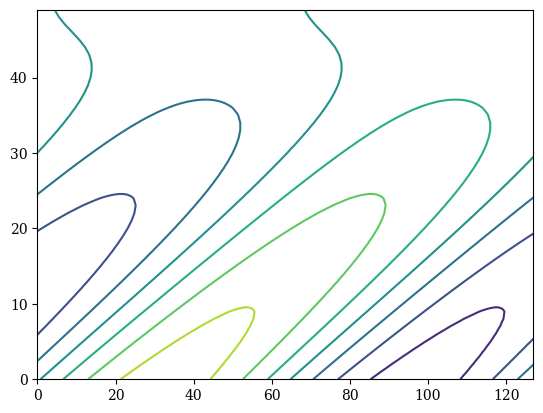

In [536]:
print(prec_recon.shape)
plt.figure()
plt.contour(prec_recon[:50,11,:])

In [338]:
# u-wind
PR=50
path:str = f"/home/b11209013/2024_Research/PowerSpec_Dycore/data/pr{PR}/"
# # range latitude
lat = np.linspace(-90, 90, 64)

lat_cond = np.where((lat>=-15)&(lat<=15))[0]
lat = lat[lat_cond]
print(lat_cond)
with h5py.File(path+"u_pr50.dat") as f:
    u = f["u"][:, 5, lat_cond]


[27 28 29 30 31 32 33 34 35 36]


In [347]:
u_half = u[:,:,64:96]

In [860]:
yyy = np.linspace(-90,90,64)
# print(yyy[21:42][:])
print(yyy[26:36][:])


xxx = np.linspace(0,360,128)
# print(xxx[55:64])
print(xxx[55:64])


[-15.71428571 -12.85714286 -10.          -7.14285714  -4.28571429
  -1.42857143   1.42857143   4.28571429   7.14285714  10.        ]
[155.90551181 158.74015748 161.57480315 164.40944882 167.24409449
 170.07874016 172.91338583 175.7480315  178.58267717]


# Precipitation regress on the wind field

In [223]:
PR = 0
with h5py.File(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/vor/PR{PR}_500_20000day_6hourly_vor.dat") as f:
    vor = f["vor"][:, :, :]
vor_anamoly = vor - vor.mean(axis=0)
print("Done")

In [363]:
lev = 0
north_boundary = 32+6 # 35
south_boundary = 32-6 # 29

west_boundary = 64-15 # 35
east_boundary = 64+15 # 35


# prec_recon = vor[:, lev, 35:, :] + vor[:, lev, :29,:] # np.mean(u_half, axis=(1,2))
# prec_recon = vor_anamoly[:, lev, 35:, :] + vor_anamoly[:, lev, :29,:] # np.mean(u_half, axis=(1,2))
# global vor_anamoly 
prec_recon = vor_anamoly[:, lev, :, :] #- vor_anamoly[:, lev, :south_boundary,:] # np.mean(u_half, axis=(1,2))


# # prec_recon = prec[:,21:43,:] # np.mean(u_half, axis=(1,2))

print(prec_recon.shape)


# prec_mean = (vor_anamoly[:, lev, north_boundary:, 35:75] + vor_anamoly[:, lev, :south_boundary, 35:75]).mean(axis=(1,2))

# index [time, 1]
prec_mean = (vor_anamoly[:, lev, north_boundary:int(north_boundary+3), west_boundary:east_boundary] - vor_anamoly[:, lev, int(south_boundary-3):south_boundary, west_boundary:east_boundary]).mean(axis=(1,2))



prec_mean = prec_mean.reshape([78000,1]) # index

(78000, 64, 128)


In [364]:

print(vor.shape)
# prec_mean = prec_recon[:, 21:43, 55:65].mean(axis=(1,2))
# prec_mean = prec_mean.reshape([78000,1])
# print(prec_mean.T.shape)
# #########################################################
# # prec_mean = prec_recon[:, 2:-1, 55:64].mean(axis=(1,2))
# # prec_mean = prec_mean.reshape([78000,1])
# # print(prec_mean.T.shape)
print(prec_recon.shape)

(78000, 20, 64, 128)
(78000, 64, 128)


In [365]:
test = prec_mean.T.dot(prec_recon.reshape([78000, 64*128])) / (prec_mean.T.dot(prec_mean))
# test = prec_mean.T.dot(prec_recon.reshape([78000, 29*128])) / (prec_mean.T.dot(prec_mean))
# test = prec_mean.T.dot(prec_recon.reshape([78000, 10*128])) / (prec_mean.T.dot(prec_mean))

########################################################
# test = prec_mean.T.dot(prec_recon.reshape([78000, 22*128])) / (prec_mean.T.dot(prec_mean))


58


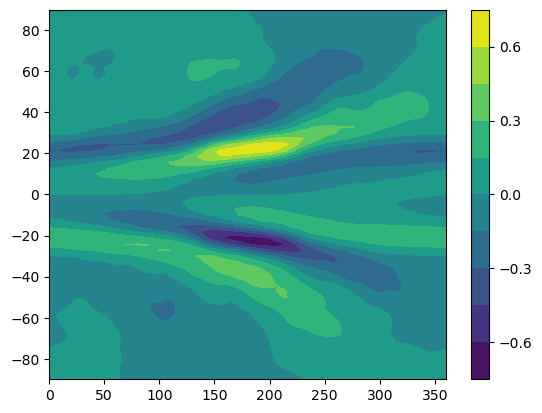

In [367]:
print(int(32+south_boundary))

xxx = np.linspace(0,360,128)
yyy = np.linspace(-90,90,64)

xxx2, yyy2 = np.meshgrid(xxx,yyy)
plt.figure()
plt.contourf(xxx2[:, :],yyy2[:, :], test.reshape([64, 128]), levels=11)
# plt.contourf(xxx2[int(32-south_boundary/2):int(32+south_boundary/2), :],yyy2[int(32-south_boundary/2):int(32+south_boundary/2), :], test.reshape([south_boundary, 128]), levels=11)

plt.colorbar()
# plt.contourf(xxx2[26:36, :],yyy2[26:36, :], test.reshape([10, 128]))
#####################################################
"method is wrong"

In [784]:
# Define the path
PR = 20
path = f"/home/b11209013/2024_Research/PowerSpec_Dycore/data/pr{PR}/"
u_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/u/PR{PR}_500_20000day_6hourly_u.dat"
v_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/v/PR{PR}_500_20000day_6hourly_v.dat"

pressure_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/z/PR{PR}_500_20000day_6hourly_z.dat"
div_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/div/PR{PR}_500_20000day_6hourly_div.dat"


    
# Efficiently read the wind data using chunked reading
with h5py.File(u_path, "r") as f_u, h5py.File(v_path, "r") as f_v, h5py.File(pressure_path, "r") as f_p, h5py.File(div_path, "r") as f_div:
    # level_index = 3  # Specific vertical level
    # level_index = 10  # Specific vertical level
    # level_index = 12  # Specific vertical level
    level_index = 0  # Specific vertical level
    
    
    # Read u and v wind fields using chunked reading
    u_all = f_u["u"][:, level_index, :, :]
    v_all = f_v["v"][:, level_index, :, :]
    print(f_p.keys())
    p_all = f_p["z"][:, level_index, :, :]
    div_all = f_div["div"][:, level_index, :, :]
    


# Check the shape of the loaded arrays
# print("Shape of u:", u.shape)
# print("Shape of v:", v.shape)
# print("Shape of p:", p.shape)
# print("Shape of p:", div.shape)
print("done")




<KeysViewHDF5 ['z']>
done


In [369]:
# level_index = 12  # Specific vertical level

u     = u_all[:, north_boundary:, :]   - u_all[:, :south_boundary,:] # u_all[:,18:47,:] #[:, level_index, :, :]
v     = v_all[:, north_boundary:, :]   - v_all[:, :south_boundary,:] # u_all[:,18:47,:] #[:, level_index, :, :]
p     = p_all[:, north_boundary:, :]   - p_all[:, :south_boundary,:] # u_all[:,18:47,:] #[:, level_index, :, :]
div   = div_all[:, north_boundary:, :] - div_all[:, :south_boundary,:] # u_all[:,18:47,:] #[:, level_index, :, :]


# v   = v_all[:,18:47,:] #[:, level_index, :, :]
# p   = p_all[:,18:47,:] #[:, level_index, :, :]
# div = div_all[:, level_index, :, :]

# reshape
time_dim, y_dim, x_dim =  u.shape[0], u.shape[1], u.shape[2]
u_reshape   = np.reshape(u, (time_dim, x_dim*y_dim)) # (time, y, x)
v_reshape   = np.reshape(v, (time_dim, x_dim*y_dim))
p_reshape   = np.reshape(p, (time_dim, x_dim*y_dim))
div_reshape = np.reshape(div, (time_dim, x_dim*y_dim))


PC_sel = prec_mean

# u   = a * prec + noise
# v   = b * prec + noise 
# p   = c * prec + noise 
# div = d * prec + noise 
a = (PC_sel.T.dot(u_reshape)) / (PC_sel.T.dot(PC_sel))  #(x*y, time) * time / ...
b = (PC_sel.T.dot(v_reshape)) / (PC_sel.T.dot(PC_sel))
c = (PC_sel.T.dot(p_reshape)) / (PC_sel.T.dot(PC_sel))
d = (PC_sel.T.dot(div_reshape)) / (PC_sel.T.dot(PC_sel))

a_reshape = np.reshape(a, (y_dim, x_dim))
b_reshape = np.reshape(b, (y_dim, x_dim))
c_reshape = np.reshape(c, (y_dim, x_dim))
d_reshape = np.reshape(d, (y_dim, x_dim))

a_final = a_reshape
b_final = b_reshape
c_final = c_reshape
d_final = d_reshape




In [303]:
d_final.min()

-0.024021517

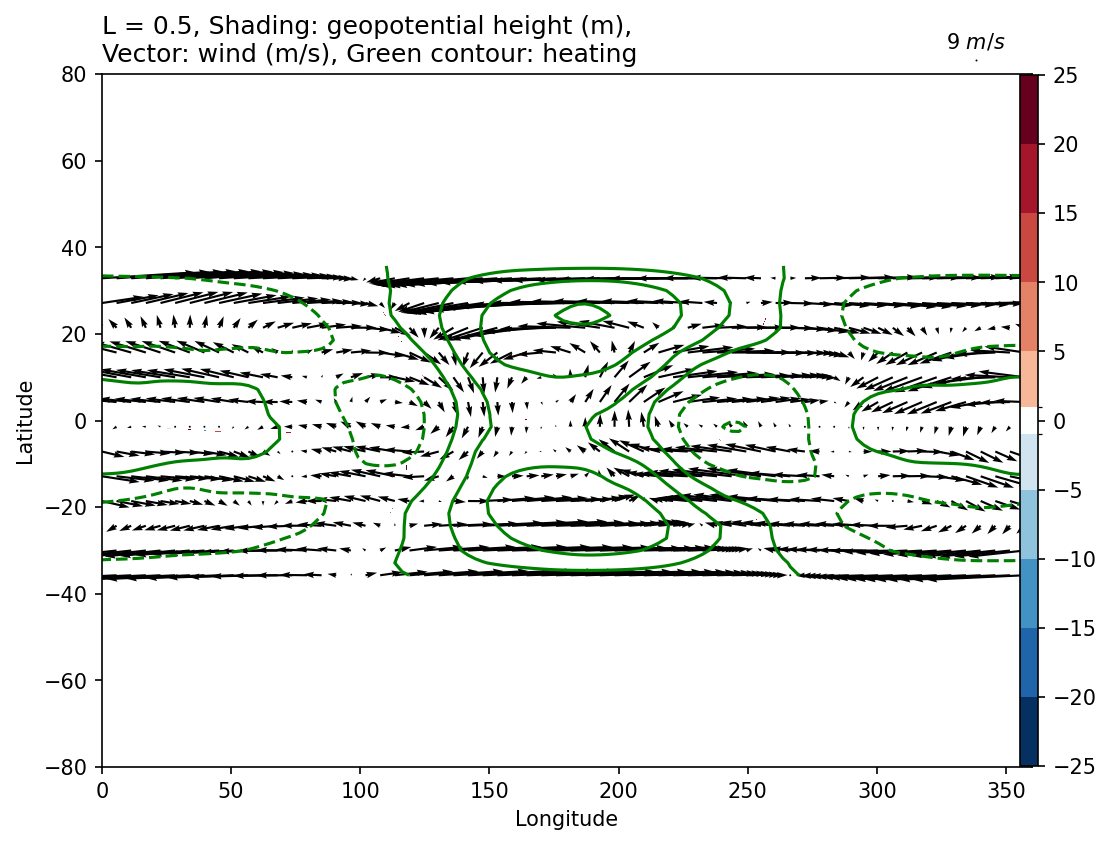

In [304]:
lonm, latm = np.meshgrid(xxx,yyy)

idx = 2
# i, j = 0, 0

plt.figure(figsize=(8,6), dpi=150.)

_,custom_levels_bar,cs = plot_contourf_near0_fixcolorbar(xxx[:], yyy[int(32-south_boundary/2):int(32+south_boundary/2)], c_final, cbar_lim = [-25, 25], my_cmap = 'RdBu_r')
# _,custom_levels_bar,cs = plot_contourf_near0_fixcolorbar(xxx, yyy, filtered_c_final, cbar_lim = [-30, 30], my_cmap = 'RdBu_r')


CT = plt.contour(xxx2[int(32-south_boundary/2):int(32+south_boundary/2), :], yyy2[int(32-south_boundary/2):int(32+south_boundary/2), :], test.reshape([south_boundary, 128]), levels=np.linspace(-3,3,11), linewidths=1.5, colors="Green")
# CT = plt.contour(xxx2[int(32-south_boundary/2):int(32+south_boundary/2), :], yyy2[int(32-south_boundary/2):int(32+south_boundary/2), :], d_final.reshape([south_boundary, 128]), levels=np.linspace(-0.02,0.02,5), linewidths=1.5, colors="Red")


threshold = 0
wind_speed = np.sqrt(a_final**2 + b_final**2)
mask = (wind_speed >= threshold) | (wind_speed <= -threshold)

a_final_nan = np.where(mask, a_final, np.nan)
b_final_nan = np.where(mask, b_final, np.nan)

# a_final_nan = np.where(mask, filtered_a_final, np.nan)
# b_final_nan = np.where(mask, filtered_b_final, np.nan)

wind_plt = plt.quiver(xxx2[int(32-south_boundary/2):int(32+south_boundary/2):idx, ::idx], yyy2[int(32-south_boundary/2):int(32+south_boundary/2):idx, ::idx], a_final_nan[::idx, ::idx], b_final_nan[::idx, ::idx], color="black", scale_units='xy', angles='xy', width=0.0023, scale=30000)
# wind_plt = plt.quiver(lonm[::idx, ::idx], latm[::idx, ::idx], a_final_nan[::idx, ::idx], b_final_nan[::idx, ::idx], color="black", scale_units='xy', angles='xy', width=0.0023, scale=4000000000)

plt.quiverkey(wind_plt,0.94,1.02,9,r'9 $m/s$',labelpos='N', labelsep =0.05, color='black')
plt.ylim([-80,80])
plt.xlabel("Longitude", fontsize=10)
plt.ylabel("Latitude", fontsize=10)
plt.title("L = 0.5, Shading: geopotential height (m),\nVector: wind (m/s), Green contour: heating", loc="left")
# add colorbar to subplots without shrinking figure
cbar_ax = plt.gcf().add_axes([0.89, 0.111, 0.015, 0.768])
# cbar_ax = plt.gcf().add_axes([0.26, 0.05, 0.5, 0.01])

cb = plt.colorbar(mappable = cs, cax=cbar_ax, spacing="proportional" )
        
cb.set_ticks(custom_levels_bar)
# cb.set_label("[hPa]")
# plt.savefig("/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/Fig4-1/L40Fig4-1.png", bbox_inches='tight', dpi=600.)


91.43614947081761

In [106]:

def plot_contourf_near0_fixcolorbar_ax(ax, X, Y ,var_near0, cbar_lim, shading_levels = 9, least_levels = 4, near0white = True, my_cmap = 'RdBu_r'):
    from matplotlib.colors import ListedColormap
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import TwoSlopeNorm
    #####
    import matplotlib.colors as colors
    # a, antialiased = 0.6, True
#     a, antialiased = 0.7, True
    # a, antialiased = 0.9, True
    a, antialiased = 1, False
    
    my_cmap = plt.colormaps[my_cmap]  
    
    # create random data with cbar_lim
    rngdata = np.random.uniform(low=cbar_lim[0], high=cbar_lim[1], size=(len(Y),len(X)))
    
    # make sure the min and Max value are included
    rngdata[0,0] = cbar_lim[0]
    rngdata[-1,-1] = cbar_lim[1]
    
    # get contour levels with random data
    cs = ax.contourf(X, Y, rngdata, levels = 9, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    auto_levels_rng = cs.levels.copy()
    plt.gca().clear()
    
    cs = ax.contourf(X, Y, var_near0, levels = auto_levels_rng, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    auto_levels2 = cs.levels.copy()
    #cbar = add_colorbar(cs)#plt.colorbar()
    #plt.show()

    if ~((np.min(auto_levels2) >= 0) | (np.max(auto_levels2) <= 0)):
        plt.gca().clear()
        
        try:
            cbar.remove()
        except:
            pass
        
        # check levels of both ends
        # if either end has contour levels less than 'least_levels', create custom levels
        if ((len(np.where(auto_levels2 > 0)[0]) < least_levels) | (len(np.where(auto_levels2 < 0)[0]) < least_levels)):
            cs = ax.contourf(X,Y,var_near0, norm=TwoSlopeNorm(0), levels = np.linspace(auto_levels_rng.min(), auto_levels_rng.max(), 100))
            auto_levels1 = cs.levels.copy()
        #     plt.colorbar()
        #     plt.show()
            plt.gca().clear()
            if (len(np.where(auto_levels2 > 0)[0]) > len(np.where(auto_levels2 < 0)[0])):
                   custom_levels = np.concatenate((np.linspace(np.min(auto_levels1), 0, least_levels+1), 
                                    auto_levels2[auto_levels2 > 0]))

            else:
                   custom_levels = np.concatenate((auto_levels2[auto_levels2 < 0], 
                                               np.linspace(0,np.max(auto_levels1),least_levels+1)))

            #custom_levels = np.unique(custom_levels)
            custom_levels_bar = custom_levels
        else:

            custom_levels = auto_levels2
            custom_levels_bar = custom_levels

        # create white shading around 0
        if near0white:
            custom_lower = custom_levels[custom_levels < 0]
            dlevel_lower = custom_lower[1] - custom_lower[0]
            custom_lower_near0 = np.concatenate((custom_lower, [0 - dlevel_lower/5]))

            custom_upper = custom_levels[custom_levels > 0]
            dlevel_upper = custom_upper[1] - custom_upper[0]
            custom_upper_near0 = np.concatenate(([dlevel_upper/5 - 0] ,custom_upper))

            custom_levels_near0 = np.concatenate((custom_lower_near0, [0], custom_upper_near0))

            mycmap_lower_near0 = my_cmap(np.linspace(0, 0.5, len(custom_levels_near0[custom_levels_near0 < 0])))
            mycmap_upper_near0 = my_cmap(np.linspace(0.5, 1, len(custom_levels_near0[custom_levels_near0 >= 0])))[1:]
            all_colors = np.vstack((mycmap_lower_near0, mycmap_upper_near0))

            all_colors[np.where(custom_levels_near0 == 0)[0]] = [1, 1, 1, 1] # set to white
            all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [1, 1, 1, 1]
            
#             all_colors[np.where(custom_levels_near0 == 0)[0]] = [0.85, 0.85, 0.85, 1] # set to gray
#             all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [0.85, 0.85, 0.85, 1]

            #all_colors[:,0:3] *= a


            mycmap_near0 = colors.LinearSegmentedColormap.from_list('mycmap_near0', all_colors)

            custom_levels = custom_levels_near0
            mycmap = mycmap_near0
        else:
            mycmap = my_cmap


        norm = colors.BoundaryNorm(boundaries=custom_levels, ncolors=256)

        cs = ax.contourf(X, Y, var_near0, levels = custom_levels, cmap=mycmap, norm=norm, alpha = a, antialiased = antialiased)
#         cbar = plt.colorbar(spacing="proportional")#cbar = add_colorbar(cs, aspect=8, pad_fraction=0.8)#

#         cbar.set_ticks(custom_levels_bar)
#         ticklabs = cbar.ax.get_yticklabels()
#         cbar.ax.set_yticklabels(ticklabs, fontsize=14)
        
    #####
    return custom_levels, custom_levels_bar, cs

#######################################################################################################

def plot_contourf_near0_fixcolorbar(X, Y ,var_near0, cbar_lim, shading_levels = 9, least_levels = 4, near0white = True, my_cmap = 'RdBu_r'):
    from matplotlib.colors import ListedColormap
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import TwoSlopeNorm
    #####
    import matplotlib.colors as colors
    # a, antialiased = 0.6, True
#     a, antialiased = 0.7, True
    # a, antialiased = 0.9, True
    a, antialiased = 1, False
    
    my_cmap = plt.colormaps[my_cmap]  
    
    # create random data with cbar_lim
    rngdata = np.random.uniform(low=cbar_lim[0], high=cbar_lim[1], size=(len(Y),len(X)))
    
    # make sure the min and Max value are included
    rngdata[0,0] = cbar_lim[0]
    rngdata[-1,-1] = cbar_lim[1]
    
    # get contour levels with random data
    cs = plt.contourf(X, Y, rngdata, levels = 9, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    auto_levels_rng = cs.levels.copy()
    plt.gca().clear()
    
    cs = plt.contourf(X, Y, var_near0, levels = auto_levels_rng, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    auto_levels2 = cs.levels.copy()
    #cbar = add_colorbar(cs)#plt.colorbar()
    #plt.show()

    if ~((np.min(auto_levels2) >= 0) | (np.max(auto_levels2) <= 0)):
        plt.gca().clear()
        
        try:
            cbar.remove()
        except:
            pass
        
        # check levels of both ends
        # if either end has contour levels less than 'least_levels', create custom levels
        if ((len(np.where(auto_levels2 > 0)[0]) < least_levels) | (len(np.where(auto_levels2 < 0)[0]) < least_levels)):
            cs = plt.contourf(X,Y,var_near0, norm=TwoSlopeNorm(0), levels = np.linspace(auto_levels_rng.min(), auto_levels_rng.max(), 100))
            auto_levels1 = cs.levels.copy()
        #     plt.colorbar()
        #     plt.show()
            plt.gca().clear()
            if (len(np.where(auto_levels2 > 0)[0]) > len(np.where(auto_levels2 < 0)[0])):
                   custom_levels = np.concatenate((np.linspace(np.min(auto_levels1), 0, least_levels+1), 
                                    auto_levels2[auto_levels2 > 0]))

            else:
                   custom_levels = np.concatenate((auto_levels2[auto_levels2 < 0], 
                                               np.linspace(0,np.max(auto_levels1),least_levels+1)))

            #custom_levels = np.unique(custom_levels)
            custom_levels_bar = custom_levels
        else:

            custom_levels = auto_levels2
            custom_levels_bar = custom_levels

        # create white shading around 0
        if near0white:
            custom_lower = custom_levels[custom_levels < 0]
            dlevel_lower = custom_lower[1] - custom_lower[0]
            custom_lower_near0 = np.concatenate((custom_lower, [0 - dlevel_lower/5]))

            custom_upper = custom_levels[custom_levels > 0]
            dlevel_upper = custom_upper[1] - custom_upper[0]
            custom_upper_near0 = np.concatenate(([dlevel_upper/5 - 0] ,custom_upper))

            custom_levels_near0 = np.concatenate((custom_lower_near0, [0], custom_upper_near0))

            mycmap_lower_near0 = my_cmap(np.linspace(0, 0.5, len(custom_levels_near0[custom_levels_near0 < 0])))
            mycmap_upper_near0 = my_cmap(np.linspace(0.5, 1, len(custom_levels_near0[custom_levels_near0 >= 0])))[1:]
            all_colors = np.vstack((mycmap_lower_near0, mycmap_upper_near0))

            all_colors[np.where(custom_levels_near0 == 0)[0]] = [1, 1, 1, 1] # set to white
            all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [1, 1, 1, 1]
            
#             all_colors[np.where(custom_levels_near0 == 0)[0]] = [0.85, 0.85, 0.85, 1] # set to gray
#             all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [0.85, 0.85, 0.85, 1]

            #all_colors[:,0:3] *= a


            mycmap_near0 = colors.LinearSegmentedColormap.from_list('mycmap_near0', all_colors)

            custom_levels = custom_levels_near0
            mycmap = mycmap_near0
        else:
            mycmap = my_cmap


        norm = colors.BoundaryNorm(boundaries=custom_levels, ncolors=256)

        cs = plt.contourf(X, Y, var_near0, levels = custom_levels, cmap=mycmap, norm=norm, alpha = a, antialiased = antialiased)
#         cbar = plt.colorbar(spacing="proportional")#cbar = add_colorbar(cs, aspect=8, pad_fraction=0.8)#

#         cbar.set_ticks(custom_levels_bar)
#         ticklabs = cbar.ax.get_yticklabels()
#         cbar.ax.set_yticklabels(ticklabs, fontsize=14)
        
    #####
    return custom_levels, custom_levels_bar, cs



In [3]:
import gc

# GPT improved

In [1534]:
y = np.linspace(-90,90,64)

In [1545]:
y[28:]

array([-10.        ,  -7.14285714,  -4.28571429,  -1.42857143,
         1.42857143,   4.28571429,   7.14285714,  10.        ,
        12.85714286,  15.71428571,  18.57142857,  21.42857143,
        24.28571429,  27.14285714,  30.        ,  32.85714286,
        35.71428571,  38.57142857,  41.42857143,  44.28571429,
        47.14285714,  50.        ,  52.85714286,  55.71428571,
        58.57142857,  61.42857143,  64.28571429,  67.14285714,
        70.        ,  72.85714286,  75.71428571,  78.57142857,
        81.42857143,  84.28571429,  87.14285714,  90.        ])

In [1532]:
# 

In [1533]:
prec_recon_normal.std()

0.9999999

# Following Pablo 2024 paper to plot Gill response

In [660]:
PR = 50
wn1_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/Wave_number/PR{PR}/PR{PR}_500_20000day_EMF_wn1_only_time_and_y.h5"

In [661]:
with h5py.File(wn1_file, "r") as f:
    EMF_wn1 = f["EMF"][:, :]

In [662]:
EMF_wn1.shape

(78000, 64)

In [663]:
y = np.linspace(-90, 90, 64)  # Example: latitude values between -90 and 90
cy = np.cos(np.deg2rad(y))
a = 6371E3

div_EMF_wn1 = np.zeros((78000,64))
print(div_EMF_wn1.shape)
for i in range(78000):
    for j in range(1,64-1):
        div_EMF_wn1[i,j] =  - ( (EMF_wn1[i,j+1] * cy[j+1]**2 - EMF_wn1[i,j-1]* cy[j-1]**2) ) / (np.deg2rad(y[j+1]) - np.deg2rad(y[j-1])) / (a*cy[j]**2)
    div_EMF_wn1[i,0]  =  - ( (EMF_wn1[i,1] * cy[1]**2 - EMF_wn1[i,0]* cy[0]**2))  / (np.deg2rad(y[2]) - np.deg2rad(y[1]))   / (a*cy[1]**2)
    div_EMF_wn1[i,-1] =  - ( (EMF_wn1[i,-1]* cy[-1]**2  - EMF_wn1[i,-2]* cy[-2]**2)) / (np.deg2rad(y[-2]) - np.deg2rad(y[-3])) / (a*cy[-2]**2)

    


(78000, 64)


/tmp/ipykernel_2095558/2393299477.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  div_EMF_wn1[i,j] =  - ( (EMF_wn1[i,j+1] * cy[j+1]**2 - EMF_wn1[i,j-1]* cy[j-1]**2) ) / (np.deg2rad(y[j+1]) - np.deg2rad(y[j-1])) / (a*cy[j]**2)
/tmp/ipykernel_2095558/2393299477.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  div_EMF_wn1[i,0]  =  - ( (EMF_wn1[i,1] * cy[1]**2 - EMF_wn1[i,0]* cy[0]**2))  / (np.deg2rad(y[2]) - np.deg2rad(y[1]))   / (a*cy[1]**2)
/tmp/ipykernel_2095558/2393299477.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  div_EMF_wn1[i,-1] =  - ( (EMF_wn1[i,-1]* cy[-1]**2  - EMF_wn1[i,-2]* cy[-2]**2)) / (np.deg2rad(y[-2]) - np.deg2rad(y[-3])) / (a*cy[-2]**2)


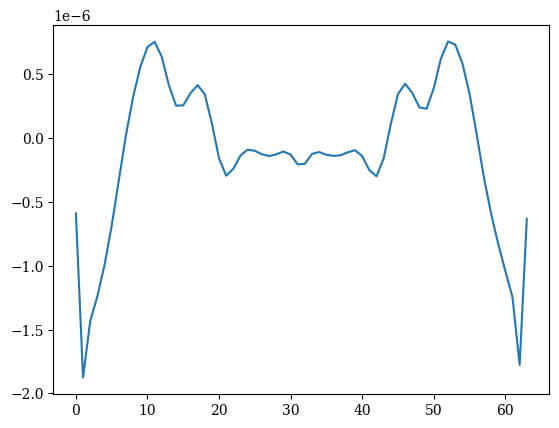

In [1248]:
plt.figure()
# plt.plot(EMF_wn1.mean(axis=0))
plt.plot(div_EMF_wn1.mean(axis=0))


In [1249]:
y[26:38]

array([-15.71428571, -12.85714286, -10.        ,  -7.14285714,
        -4.28571429,  -1.42857143,   1.42857143,   4.28571429,
         7.14285714,  10.        ,  12.85714286,  15.71428571])

In [1250]:
# div_EMF_eq = div_EMF_wn1[:,26:38].mean(axis=1)
div_EMF_eq = div_EMF_wn1[:,32]


In [1251]:
div_EMF_eq_normal = (div_EMF_eq - div_EMF_eq.mean()) / div_EMF_eq.std()

In [1323]:
positive = np.where(div_EMF_eq_normal>4)
negative = np.where(div_EMF_eq_normal<-1)

In [1324]:
positive = np.asarray(positive)

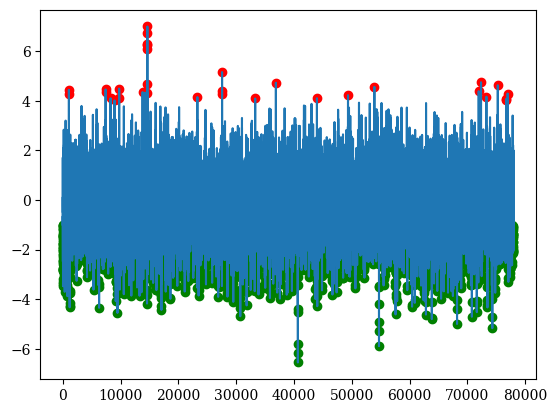

In [1325]:
plt.figure()
plt.plot(div_EMF_eq_normal)
plt.scatter(positive, div_EMF_eq_normal[positive], color="Red")
plt.scatter(negative, div_EMF_eq_normal[negative], color="Green")


In [782]:
PR = 0
u_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/u/PR{PR}_500_20000day_6hourly_u.dat"
v_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/v/PR{PR}_500_20000day_6hourly_v.dat"
z_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/z/PR{PR}_500_20000day_6hourly_z.dat"

pressure_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/z/PR{PR}_500_20000day_6hourly_z.dat"


    
# Efficiently read the wind data using chunked reading
with h5py.File(u_path, "r") as f_u, h5py.File(v_path, "r") as f_v, h5py.File(z_path, "r") as f_z:

    level_index = 0  # Specific vertical level

    u_all = f_u["u"][:, level_index, :, :]
    v_all = f_v["v"][:, level_index, :, :]
    z_all = f_z["z"][:, level_index, :, :]
    

In [1172]:
print(z_all.shape)

(78000, 64, 128)


In [1326]:
time_array_pos = np.asarray(positive[0])  # Example positive time indices
time_array_neg = np.asarray(negative[0])  # Example negative time indices

# time_array_pos = time_array_pos[time_array_pos<5000]
# time_array_neg = time_array_neg[time_array_neg<4]
print(time_array_pos)
# Pre-allocate arrays for the rolled u_data for both positive and negative times
u_rolled_pos = np.zeros(((time_array_pos.shape[0], 64, 128)))
u_rolled_neg = np.zeros(((time_array_neg.shape[0], 64, 128)))
# print(u_rolled_pos.shape)
# print(u_rolled_neg.shape)

# Loop over the positive time indices
for idx in range(len(time_array_pos)):
    pos_time_idx = time_array_pos[idx]
    # Find the x-axis index of the maximum value in the tropical region (y[26] to y[38])
    # We are taking the mean across latitudes y[26] to y[38] and finding the max in x
    tropic_u_mean = u_all[pos_time_idx, 32, :]#.mean(axis=0)
    max_idx_pos = np.argmax(tropic_u_mean)  # Find the longitude of max value in the tropics

    # Calculate the roll amount to center the max value globally at x_dim//2 (center of x-axis)
    roll_amount_pos = (u_all.shape[2] // 2) - max_idx_pos

    # Apply rolling globally for all y latitudes
    for j in range(u_all.shape[1]):  # Loop over y dimension (all latitudes)
        u_rolled_pos[idx, j, :] = np.roll(u_all[pos_time_idx, j, :], roll_amount_pos)

# Loop over the negative time indices
for idx in range(len(time_array_neg)):
    neg_time_idx = time_array_neg[idx]

    # Find the x-axis index of the maximum value in the tropical region (y[26] to y[38])
    tropic_u_mean = u_all[neg_time_idx, 32, :]#.mean(axis=0)
    max_idx_neg = np.argmax(tropic_u_mean)  # Find the longitude of max value in the tropics

    # Calculate the roll amount to center the max value globally at x_dim//2 (center of x-axis)
    roll_amount_neg = (u_all.shape[2] // 2) - max_idx_neg

    # Apply rolling globally for all y latitudes
    for j in range(u_all.shape[1]):  # Loop over y dimension (all latitudes)
        u_rolled_neg[idx, j, :] = np.roll(u_all[neg_time_idx, j, :], roll_amount_neg)

# After rolling, subtract the negative time index data from the positive time index data
u_difference = u_rolled_pos[:, :, :].mean(axis=0) #- u_rolled_neg[:, :, :].mean(axis=0)
print(u_rolled_pos.shape)
print(u_rolled_neg.shape)

# u_difference now contains the difference between the rolled u_data for positive and negative time indices
print("Difference between positive and negative time indices computed!")


[ 1061  1062  7411  7412  8266  8955  9759  9760 13807 14231 14626 14635
 14636 14637 14638 14639 14640 23284 27554 27555 27556 33287 36865 43965
 49341 53903 71950 72350 73283 75252 76695 76696 76956]
(33, 64, 128)
(11348, 64, 128)
Difference between positive and negative time indices computed!


Text(0.5, 1.0, 'Day 1000th Original u')

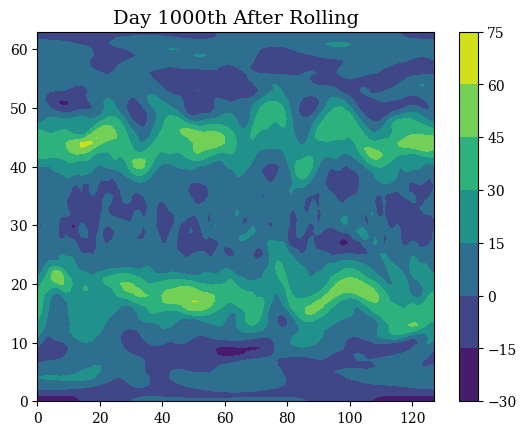

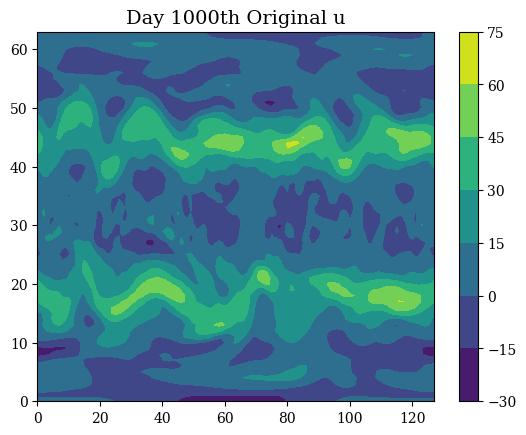

In [1327]:
Day = 1000
u_rolled_pos_test = np.zeros(((1,64,128)))
tropic_u_mean = u_all[Day, 32, :]#.mean(axis=0)
max_idx_pos = np.argmax(tropic_u_mean)  # Find the longitude of max value in the tropics

# Calculate the roll amount to center the max value globally at x_dim//2 (center of x-axis)
roll_amount_pos = (u_all.shape[2] // 2) - max_idx_pos

# Apply rolling globally for all y latitudes
for j in range(u_all.shape[1]):  # Loop over y dimension (all latitudes)
    u_rolled_pos_test[0, j, :] = np.roll(u_all[Day, j, :], roll_amount_pos)
    
plt.figure()
plt.contourf(u_rolled_pos_test[0])
plt.colorbar()
plt.title(f"Day {Day}th After Rolling")


plt.figure()
plt.contourf(u_all[Day])
plt.colorbar()
plt.title(f"Day {Day}th Original u")



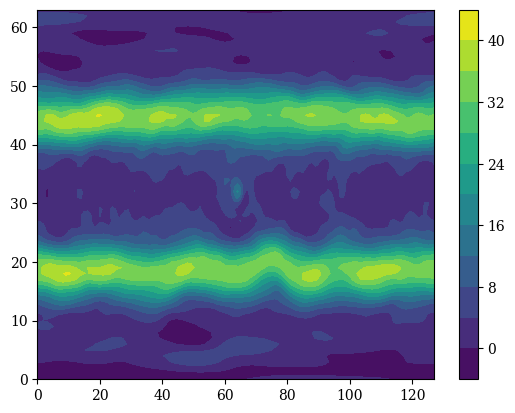

In [1328]:
plt.figure()
plt.contourf(u_difference, levels=11)
plt.colorbar()

In [1340]:
test = np.argmax(u_all[0, 28:36, :], axis=1)
print(test)

# plt.figure()
# plt.contourf(

[51 13 13 12 44 46 46 45]


In [1315]:
# time_array_pos = np.asarray(positive)[0]  # Example positive time indices
# time_array_neg = np.asarray(negative)[0]  # Example negative time indices

# Pre-allocate arrays for the rolled v_data for both positive and negative times
v_rolled_pos = np.zeros(((time_array_pos.shape[0], 64, 128)))
v_rolled_neg = np.zeros(((time_array_neg.shape[0], 64, 128)))

# Loop over the positive time indices
for idx in range(len(time_array_pos)):
    pos_time_idx = time_array_pos[idx]

    # Find the x-axis index of the maximum value in the tropical region (y[26] to y[38])
    # We are taking the mean across latitudes y[26] to y[38] and finding the max in x
    tropic_v_mean = v_all[pos_time_idx, 32 :]#.mean(axis=0)
    max_idx_pos = np.argmax(tropic_v_mean)  # Find the longitude of max value in the tropics

    # Calculate the roll amount to center the max value globally at x_dim//2 (center of x-axis)
    roll_amount_pos = (v_all.shape[2] // 2) - max_idx_pos

    # Apply rolling globally for all y latitudes
    for j in range(v_all.shape[1]):  # Loop over y dimension (all latitudes)
        v_rolled_pos[idx, j, :] = np.roll(v_all[pos_time_idx, j, :], roll_amount_pos)

# Loop over the negative time indices
for idx in range(len(time_array_neg)):
    neg_time_idx = time_array_neg[idx]

    # Find the x-axis index of the maximum value in the tropical region (y[26] to y[38])
    tropic_v_mean = v_all[neg_time_idx, 32, :]# .mean(axis=0)
    max_idx_neg = np.argmax(tropic_v_mean)  # Find the longitude of max value in the tropics

    # Calculate the roll amount to center the max value globally at x_dim//2 (center of x-axis)
    roll_amount_neg = (v_all.shape[2] // 2) - max_idx_neg

    # Apply rolling globally for all y latitudes
    for j in range(v_all.shape[1]):  # Loop over y dimension (all latitudes)
        v_rolled_neg[idx, j, :] = np.roll(v_all[neg_time_idx, j, :], roll_amount_neg)

# After rolling, subtract the negative time index data from the positive time index data
v_difference = v_rolled_pos[:, :, :].mean(axis=0) #- v_rolled_neg[:, :, :].mean(axis=0)

# v_difference now contains the difference between the rolled v_data for positive and negative time indices
print("Difference between positive and negative time indices computed!")


Difference between positive and negative time indices computed!


In [1316]:
# time_array_pos = np.asarray(positive)[0]  # Example positive time indices
# time_array_neg = np.asarray(negative)[0]  # Example negative time indices
print(time_array_pos.shape[0])

# Pre-allocate arrays for the rolled z_data for both positive and negative times
z_rolled_pos = np.zeros(((time_array_pos.shape[0], 64, 128)))
z_rolled_neg = np.zeros(((time_array_neg.shape[0], 64, 128)))

# Loop over the positive time indices
for idx in range(len(time_array_pos)):
    pos_time_idx = time_array_pos[idx]
    
    # Find the x-axis index of the maximum value for the current time and y level for positive time index (j=32)
    max_idx_pos = np.argmax(z_all[pos_time_idx, 32, :])
    roll_amount_pos = (z_all.shape[2] // 2) - max_idx_pos
    # Apply rolling for all y levels (j dimension)
    for j in range(z_all.shape[1]):  # Loop over y dimension
        z_rolled_pos[idx, j, :] = np.roll(z_all[pos_time_idx, j, :], roll_amount_pos)

# Loop over the negative time indices
for idx in range(len(time_array_neg)):
    neg_time_idx = time_array_neg[idx]
    
    # Find the x-axis index of the maximum value for the current time and y level for negative time index (j=32)
    max_idx_neg = np.argmax(z_all[neg_time_idx, 26:39, :])
    roll_amount_neg = (z_all.shape[2] // 2) - max_idx_neg
    # Apply rolling for all y levels (j dimension)
    for j in range(z_all.shape[1]):  # Loop over y dimension
        z_rolled_neg[idx, j, :] = np.roll(z_all[neg_time_idx, j, :], roll_amount_neg)

# After rolling, subtract the negative time index data from the positive time index data
z_difference = z_rolled_pos[:, :, :].mean(axis=0) #- z_rolled_neg[:, :, :].mean(axis=0)

# z_difference now contains the difference between the rolled z_data for positive and negative time indices
print("Difference between positive and negative time indices computed!")


6
Difference between positive and negative time indices computed!


In [442]:
u_rolled_mean = u_rolled.mean(axis=0)
v_rolled_mean = v_rolled.mean(axis=0)
z_rolled_mean = z_rolled.mean(axis=0)



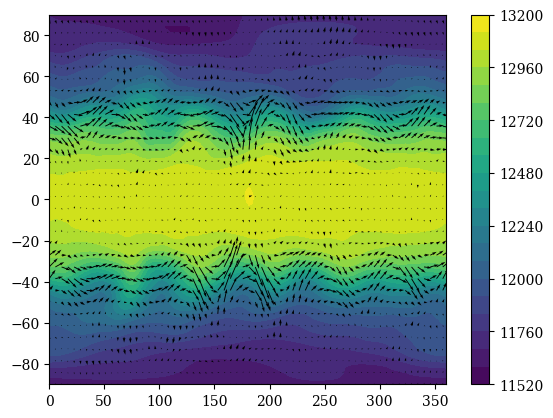

In [1321]:
idx = 2
plt.figure()
plt.contourf(lonm, latm, z_difference, levels=21)
plt.colorbar()
wind_plt = plt.quiver(lonm[::idx, ::idx], latm[::idx, ::idx], u_difference[::idx, ::idx], v_difference[::idx, ::idx], color="black", scale_units='xy', angles='xy', width=0.0023, scale=5)


In [464]:
u_difference.min()

-1.562954

In [456]:
u_difference.shape

(64, 128)

In [486]:
time_array_pos.shape

(1, 10878)

In [492]:
negative.shape

(1, 9583)

In [ ]:

with h5py.File("/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR50/uD/PR50_500_20000day_6hourly_uD.dat", "r") as f:
    # print(f.keys())
    uD = f["-uD"][:, :]


In [981]:
uD.shape

(78000, 20, 64, 128)

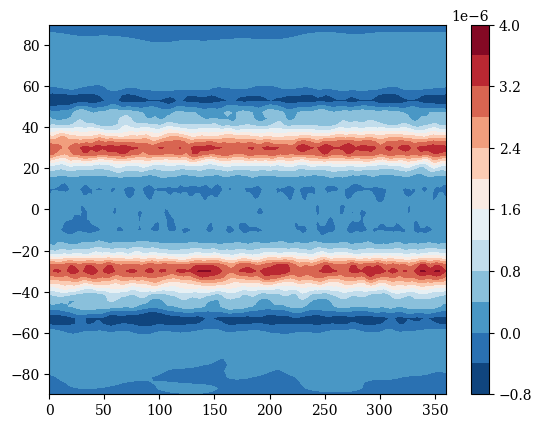

In [989]:
plt.figure()
plt.contourf(lonm, latm, uD[:,1].mean(axis=0), levels=11, cmap="RdBu_r")
plt.colorbar()

# Cal -u'D' k=1

In [990]:
# hypervariables
wave_number = 1
PR = 0 * 10 # 0, 0.1, 0.2, 0.3, 0.4, 0.5

if PR == 0:
    uD_file =  f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR0/uD/PR0_500_20000day_6hourly_uD.dat"
    idx = 0
else:
    uD_file =  f"PR{PR}_50_500_20000day_uD.h5"
    idx    =  PR - 1

print("Wave number:", wave_number)
print("idx:", idx)


Wave number: 1
idx: 0


In [991]:
uD_file0  = h5py.File(uD_file, "r")
uD_0  = np.asarray(uD_file0["-uD"][:,:,:,:])


In [ ]:
div_uD = np.zeros_like(uD_0)

y = np.linspace(-90, 90, 64)  # Example: latitude values between -90 and 90
cy = np.cos(np.deg2rad(y))
a = 6371E3

print(div_uD.shape)
for i in range(78000):
    for k in range(20):
        for j in range(1,64-1):
            div_uD[i,k,j,:] =  - ( (uD_0[i,k,j+1] * cy[j+1]**2 - uD_0[i,k,j-1]* cy[j-1]**2) ) / (np.deg2rad(y[j+1]) - np.deg2rad(y[j-1])) / (a*cy[j]**2)
    # div_uD[i,0]  =  - ( (uD_0[i,1] * cy[1]**2 - uD_0[i,0]* cy[0]**2))  / (np.deg2rad(y[2]) - np.deg2rad(y[1]))   / (a*cy[1]**2)
    # div_uD[i,-1] =  - ( (uD_0[i,-1]* cy[-1]**2  - uD_0[i,-2]* cy[-2]**2)) / (np.deg2rad(y[-2]) - np.deg2rad(y[-3])) / (a*cy[-2]**2)

    


(78000, 20, 64, 128)


In [1687]:
div_uD.shape

(78000, 20, 64, 128)

# uD wn1 

In [1158]:
# 09/18 15:17 before Climate Dynamic Class
# First to see whether div_uD completerd or not
print(div_uD.shape)


(78000, 20, 64, 128)


In [1688]:
import time
start = time.time()

uD0_fft = np.fft.fft(div_uD[:,:,43:,:], axis=3) # (19500, 20, 64, 128)

end = time.time()
print("執行時間：%f 秒" % (end - start))

執行時間：71.620768 秒


In [1689]:
# because it's even (128), keep the last one, then the others are 0
uD0_fft_fft_wn1 = np.zeros(uD0_fft.shape, dtype=np.complex_)

uD0_fft_fft_wn1[:,:,:,wave_number] = uD0_fft[:,:,:,wave_number] 

uD0_fft_fft_wn1[:,:,:,-wave_number] = uD0_fft[:,:,:,-wave_number] 


In [1690]:
uD0_ifft = ifft(uD0_fft_fft_wn1[:,:,:,:], axis=3)

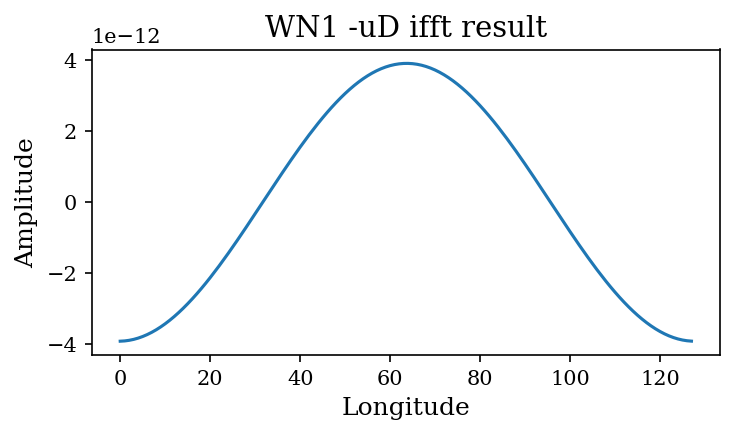

In [1713]:
# Check whether wave number is equal to the "number of wave"
import random
# Check wave number 1 wave on x axis
day_random = random.randint(0,78000)
z_random = random.randint(0,19)
# y_random = random.randint(0,63)
y_random = random.randint(0,21) # 43: 
x_random = random.randint(0,127)

fig, ax = plt.subplots(1, figsize=(5,3), dpi=150.)
ax.plot(uD0_ifft[day_random,z_random,y_random,:])
ax.set_title("WN1 -uD ifft result")
ax.set_xlabel("Longitude")
ax.set_ylabel("Amplitude")
plt.tight_layout()

In [1692]:
uD0_ifft_mean = np.mean(uD0_ifft, axis=(0, 1, 3))

In [1694]:
uD0_ifft.shape

(78000, 20, 21, 128)

In [1163]:
uD0_ifft.shape

(78000, 20, 22, 128)

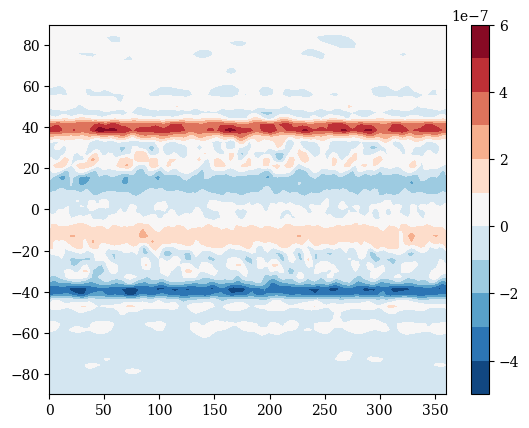

In [1203]:
# Plotting the averaged EMF
plt.figure()
# plt.plot(np.linspace(-90,90,64), uD0_ifft_mean, label="L = Dry, WN1")
# plt.contourf(lonm[21:43,:], latm[21:43,:], uD0_ifft[:,4].mean(axis=0) * 86400, levels=11, cmap="RdBu_r")
plt.contourf(lonm, latm, div_uD[:,2].mean(axis=0)* 86400 , levels=11, cmap="RdBu_r")

plt.colorbar()
# plt.legend()
# plt.title("WN1 EMF", fontsize=14)
# plt.xlabel("Latitude")
# plt.ylabel("Amplitude")
# plt.show()

In [1695]:
uD0_ifft_time = np.mean(uD0_ifft[:,3,:,:], axis=(1,2))
uD0_ifft_time_normal = (uD0_ifft_time - uD0_ifft_time.mean()) / uD0_ifft_time.std()

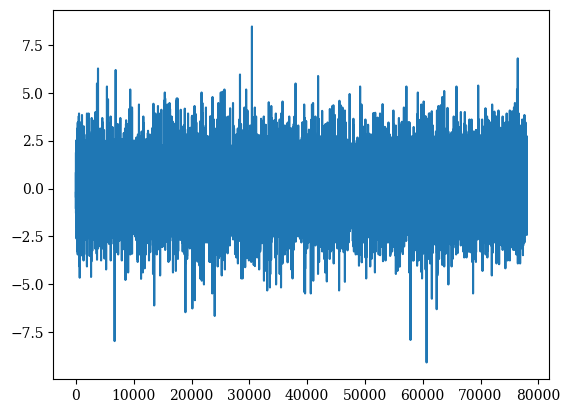

In [1696]:
plt.figure()
plt.plot(uD0_ifft_time_normal)

In [1697]:
positive = np.where(uD0_ifft_time_normal>1.5)
negative = np.where(uD0_ifft_time_normal<-1.5)
positive = np.asarray(positive)
negative = np.asarray(negative)
positive.shape

(1, 4575)

/home/PeterChang/miniconda3/envs/ML22/lib/python3.12/site-packages/matplotlib/contour.py:1515: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/home/PeterChang/miniconda3/envs/ML22/lib/python3.12/site-packages/matplotlib/contour.py:1516: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/home/PeterChang/miniconda3/envs/ML22/lib/python3.12/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


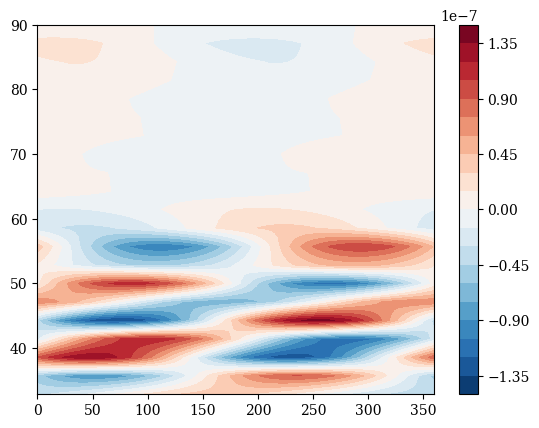

In [1699]:
# print(uD0_ifft[positive][0].shape)
level_idx = 3
plt.figure()
# plt.plot(np.linspace(-90,90,64), uD0_ifft_mean, label="L = Dry, WN1")
plt.contourf(lonm[43:,:], latm[43:,:], (uD0_ifft[positive[0,:],level_idx]).mean(axis=0) * 86400, levels=21, cmap="RdBu_r")
plt.colorbar()

In [ ]:
print("Ho")

In [1063]:
y = np.linspace(-90,90,64)
print(y[21:43])

[-30.         -27.14285714 -24.28571429 -21.42857143 -18.57142857
 -15.71428571 -12.85714286 -10.          -7.14285714  -4.28571429
  -1.42857143   1.42857143   4.28571429   7.14285714  10.
  12.85714286  15.71428571  18.57142857  21.42857143  24.28571429
  27.14285714  30.        ]


In [1215]:
div_uD_sel = div_uD[:,3,:,:].mean(axis=(1,2))
div_uD_sel = div_uD_sel.reshape([78000,1])
print(div_uD_sel.T.shape)

(1, 78000)


In [1226]:
div_uD_reshape = np.reshape(div_uD[:,3], (time_dim, y_dim*x_dim))
c = (div_uD_sel.T.dot(div_uD_reshape)) / (div_uD_sel.T.dot(div_uD_sel))


In [1218]:
div_uD.shape

(78000, 20, 64, 128)

In [1228]:
c_final = np.reshape(c, (y_dim, x_dim))

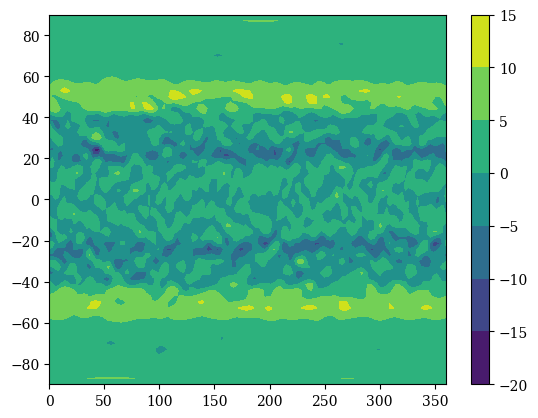

In [1230]:
plt.figure()
plt.contourf(lonm, latm, c_final)
plt.colorbar()

# vor anamoly wn1

In [3]:
# This program is to form the data into pkl file
# Basic setting
# # import package
import h5py
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
# colors
import matplotlib.colors as colors
import matplotlib as mpl  # Add this line


rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255 # By Nick
# colors = np.array([[112,115,115],[137,209,201], [18,78,120], [242,187,5],[215,78,9],[255,16,7]])/255


In [81]:
# Define the path
PR = 50
# path = f"/home/b11209013/2024_Research/PowerSpec_Dycore/data/pr{PR}/"
u_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/u/PR{PR}_500_20000day_6hourly_u.dat"
# v_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/v/PR{PR}_500_20000day_6hourly_v.dat"

p_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/p/PR{PR}_500_20000day_6hourly_p.dat"
z_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/z/PR{PR}_500_20000day_6hourly_z.dat"

div_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/div/PR{PR}_500_20000day_6hourly_div.dat"
vor_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/vor/PR{PR}_500_20000day_6hourly_vor.dat"


    
# Efficiently read the wind data using chunked reading
# with h5py.File(u_path, "r") as f_u, h5py.File(v_path, "r") as f_v, h5py.File(p_path, "r") as f_p, h5py.File(z_path, "r") as f_z, h5py.File(vor_path, "r") as f_vor:
# # with h5py.File(pressure_path,"r") as f_p:
#     level_index = 0  # Specific vertical level
#     print(f_z.keys())
#     # Read u and v wind fields using chunked reading
#     u = f_u["u"][:, level_index, :, :]
#     v = f_v["v"][:, level_index, :, :]
#     print(f_z.keys())
#     p = f_p["p"][:, level_index, :, :]
#     z = f_z["z"][:, level_index, :, :]
#     print(f_p.keys())
#     # div = f_div["div"][:, level_index, :, :]
#     vor = f_vor["vor"][:, level_index, :, :]
level_index = 8



# with h5py.File(v_path, "r") as f_v:
#     v = f_v["v"][:, level_index, :, :]


with h5py.File(p_path, "r") as f_p:
    p = f_p["p"][:, level_index, :, :]
    
with h5py.File(z_path, "r") as f_z:
    z = f_z["z"][:, level_index, :, :]

with h5py.File(vor_path, "r") as f_vor:
    vor = f_vor["vor"][:, level_index, :, :]
print("done")
print(p.mean())

done
42496.375


In [82]:
with h5py.File("PR50_500_20000day_6hourly_v.dat", "r") as f_v:
    v = f_v["v"][:, level_index, :, :]

with h5py.File(div_path, "r") as f_div:
    div = f_div["div"][:, level_index, :, :]

In [83]:
prec_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec.dat"
with h5py.File(prec_path, "r") as f_prec:
    prec = f_prec["prec"][:, :, :]

prec *= 86400
prec_anamoly = prec - prec.mean(axis=0)


In [84]:
with h5py.File(u_path, "r") as f_u:
    u = f_u["u"][:, level_index, :, :]
    
p_anamoly   = p - p.mean(axis=0)
u_anamoly   = u - u.mean(axis=0)
v_anamoly   = v - v.mean(axis=0)
z_anamoly   = z - z.mean(axis=0)
vor_anamoly = vor - vor.mean(axis=0)
div_anamoly = div - div.mean(axis=0)

In [85]:
north_boundary = 32+6 # 35
south_boundary = 32-6 # 29

yyy = np.linspace(-90,90,64)
# print(yyy[21:42][:])
print(yyy[26:36][:])


xxx = np.linspace(0,360,128)
# print(xxx[55:64])
print(xxx[55:64])
xxx2, yyy2 = np.meshgrid(xxx,yyy)

print(north_boundary)
print(south_boundary)
print(yyy[38:38+6])
yyy[26-6:26]
print(vor_anamoly.shape)
# del vor_anamoly_fft
print(p.mean())

[-15.71428571 -12.85714286 -10.          -7.14285714  -4.28571429
  -1.42857143   1.42857143   4.28571429   7.14285714  10.        ]
[155.90551181 158.74015748 161.57480315 164.40944882 167.24409449
 170.07874016 172.91338583 175.7480315  178.58267717]
38
26
[18.57142857 21.42857143 24.28571429 27.14285714 30.         32.85714286]
(78000, 64, 128)
42496.375


In [86]:
import time
start = time.time()

vor_anamoly_fft = np.fft.fft(vor_anamoly[:,:,:], axis=2)
div_anamoly_fft = np.fft.fft(div_anamoly[:,:,:], axis=2) #- np.fft.fft(vor_anamoly[:,:,int(south_boundary-6):int(south_boundary),:], axis=3) # (19500, 20, 64, 128)
p_anamoly_fft   = np.fft.fft(p_anamoly[:,:,:], axis=2)
z_anamoly_fft   = np.fft.fft(z_anamoly[:,:,:], axis=2)
u_anamoly_fft   = np.fft.fft(u_anamoly[:,:,:], axis=2)
v_anamoly_fft   = np.fft.fft(v_anamoly[:,:,:], axis=2)

prec_anamoly_fft   = np.fft.fft(prec_anamoly[:,:,:], axis=2)
end = time.time()
print("執行時間：%f 秒" % (end - start))

執行時間：34.374800 秒


In [87]:
# wave_number_min = 1
# wave_number_max = 2
# # because it's even (128), keep the last one, then the others are 0
# vor_anamoly_fft_wn1 = np.zeros(vor_anamoly_fft.shape, dtype=np.complex_)

# vor_anamoly_fft_wn1[:,:,wave_number_min:wave_number_max] = vor_anamoly_fft[:,:,wave_number_min:wave_number_max] 

# vor_anamoly_fft_wn1[:,:,-wave_number_max:-wave_number_min] = vor_anamoly_fft[:,:,-wave_number_max:-wave_number_min] 

# ###
# prec_anamoly_fft_wn1 = np.zeros(prec_anamoly_fft.shape, dtype=np.complex_)

# prec_anamoly_fft_wn1[:,:,wave_number_min:wave_number_max] = prec_anamoly_fft[:,:,wave_number_min:wave_number_max] 

# prec_anamoly_fft_wn1[:,:,-wave_number_max:-wave_number_min] = prec_anamoly_fft[:,:,-wave_number_max:-wave_number_min] 

# ###
# # div_anamoly_fft_wn1 = np.zeros(div_anamoly_fft.shape, dtype=np.complex_)

# # div_anamoly_fft_wn1[:,:,wave_number_min:wave_number_max] = div_anamoly_fft[:,:,wave_number_min:wave_number_max] 

# # div_anamoly_fft_wn1[:,:,-wave_number_max:-wave_number_min] = div_anamoly_fft[:,:,-wave_number_max:-wave_number_min] 


# ###
# p_anamoly_fft_wn1 = np.zeros(p_anamoly_fft.shape, dtype=np.complex_)

# p_anamoly_fft_wn1[:,:,wave_number_min:wave_number_max] = p_anamoly_fft[:,:,wave_number_min:wave_number_max] 

# p_anamoly_fft_wn1[:,:,-wave_number_max:-wave_number_min] = p_anamoly_fft[:,:,-wave_number_max:-wave_number_min] 

# ###
# z_anamoly_fft_wn1 = np.zeros(z_anamoly_fft.shape, dtype=np.complex_)

# z_anamoly_fft_wn1[:,:,wave_number_min:wave_number_max] = z_anamoly_fft[:,:,wave_number_min:wave_number_max] 

# z_anamoly_fft_wn1[:,:,-wave_number_max:-wave_number_min] = z_anamoly_fft[:,:,-wave_number_max:-wave_number_min] 

# ###
# u_anamoly_fft_wn1 = np.zeros(u_anamoly_fft.shape, dtype=np.complex_)

# u_anamoly_fft_wn1[:,:,wave_number_min:wave_number_max] = u_anamoly_fft[:,:,wave_number_min:wave_number_max] 

# u_anamoly_fft_wn1[:,:,-wave_number_max:-wave_number_min] = u_anamoly_fft[:,:,-wave_number_max:-wave_number_min] 

# ###
# v_anamoly_fft_wn1 = np.zeros(v_anamoly_fft.shape, dtype=np.complex_)

# v_anamoly_fft_wn1[:,:,wave_number_min:wave_number_max] = v_anamoly_fft[:,:,wave_number_min:wave_number_max] 

# v_anamoly_fft_wn1[:,:,-wave_number_max:-wave_number_min] = v_anamoly_fft[:,:,-wave_number_max:-wave_number_min] 


In [88]:
# prec_anamol_ifft = np.fft.ifft(prec_anamoly_fft_wn1[:,:,:], axis=2)


In [89]:
# vor_anamol_ifft = np.fft.ifft(vor_anamoly_fft_wn1[:,:,:], axis=2)
# # div_anamol_ifft = np.fft.ifft(div_anamoly_fft_wn1[:,:,:], axis=2)

# p_anamol_ifft   = np.fft.ifft(p_anamoly_fft_wn1[:,:,:], axis=2)
# z_anamol_ifft   = np.fft.ifft(z_anamoly_fft_wn1[:,:,:], axis=2)
# u_anamol_ifft   = np.fft.ifft(u_anamoly_fft_wn1[:,:,:], axis=2)
# v_anamol_ifft   = np.fft.ifft(v_anamoly_fft_wn1[:,:,:], axis=2)




In [90]:
# # Check whether wave number is equal to the "number of wave"
# # Plotting for check
# import random
# # Check wave number 1 wave on x axis
# day_random = random.randint(0,78000)
# # z_random = random.randint(0,19)
# # y_random = random.randint(0,63)
# y_random = random.randint(0,63) # 43: 
# x_random = random.randint(0,127)

# fig, ax = plt.subplots(1, figsize=(5,3), dpi=150.)
# ax.plot(prec_anamol_ifft[day_random,y_random,:])
# ax.set_title("WN1 v anamoly ifft result")
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Amplitude")
# plt.tight_layout()

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Perform FFT for wave numbers 1 to 6
wave_number_min = 1
wave_number_max = 7  # Set this to include wave numbers 1 to 6 (1:6)

# Keep only wave numbers 1 to 6 (positive and negative), setting others to zero
def extract_wave_numbers_1_to_6(data_fft, wave_number_min=1, wave_number_max=7):
    wn_fft = np.zeros(data_fft.shape, dtype=np.complex_)

    # Keep wave numbers 1 to 6 (positive frequencies)
    wn_fft[:, :, wave_number_min:wave_number_max] = data_fft[:, :, wave_number_min:wave_number_max]

    # Keep wave numbers -6 to -1 (negative frequencies)
    wn_fft[:, :, -wave_number_max:-wave_number_min] = data_fft[:, :, -wave_number_max:-wave_number_min]

    return wn_fft

# Apply the extraction for all variables
vor_anamoly_fft_wn1_to_6 = extract_wave_numbers_1_to_6(vor_anamoly_fft)
prec_anamoly_fft_wn1_to_6 = extract_wave_numbers_1_to_6(prec_anamoly_fft)
p_anamoly_fft_wn1_to_6 = extract_wave_numbers_1_to_6(p_anamoly_fft)
z_anamoly_fft_wn1_to_6 = extract_wave_numbers_1_to_6(z_anamoly_fft)
u_anamoly_fft_wn1_to_6 = extract_wave_numbers_1_to_6(u_anamoly_fft)
v_anamoly_fft_wn1_to_6 = extract_wave_numbers_1_to_6(v_anamoly_fft)
div_anamoly_fft_wn1_to_6 = extract_wave_numbers_1_to_6(div_anamoly_fft)


# Inverse FFT to transform back to the spatial domain
prec_anamol_ifft = np.fft.ifft(prec_anamoly_fft_wn1_to_6, axis=2).real
vor_anamol_ifft = np.fft.ifft(vor_anamoly_fft_wn1_to_6, axis=2).real
p_anamol_ifft = np.fft.ifft(p_anamoly_fft_wn1_to_6, axis=2).real
z_anamol_ifft = np.fft.ifft(z_anamoly_fft_wn1_to_6, axis=2).real
u_anamol_ifft = np.fft.ifft(u_anamoly_fft_wn1_to_6, axis=2).real
v_anamol_ifft = np.fft.ifft(v_anamoly_fft_wn1_to_6, axis=2).real
div_anamol_ifft = np.fft.ifft(div_anamoly_fft_wn1_to_6, axis=2).real


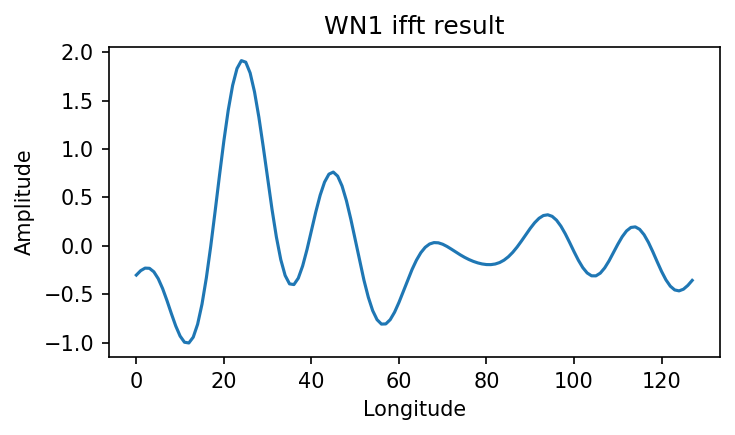

In [92]:
# Plotting the result for a random day and latitude
day_random = random.randint(0, vor_anamol_ifft.shape[0] - 1)
y_random = random.randint(0, vor_anamol_ifft.shape[1] - 1)

fig, ax = plt.subplots(1, figsize=(5, 3), dpi=150.)
ax.plot(prec_anamol_ifft[day_random, y_random, :], label='Wave number 1~6')
ax.set_title("WN1 ifft result")
ax.set_xlabel("Longitude")
ax.set_ylabel("Amplitude")
plt.tight_layout()
plt.show()

# plt.plot(prec_anamol_ifft[day_random,32,:]/np.std(prec_anamol_ifft[day_random,32,:]))
# plt.plot(prec_recon[day_random,11,:]/np.std(prec_recon[day_random,11,:]))

In [93]:
# import numpy as np
# import matplotlib.pyplot as plt
# import random

# # Perform FFT for wave number 1
# wave_number_min = 1
# wave_number_max = 2

# # Keep only wave number 1 (positive and negative), setting others to zero
# def extract_wave_number_1(data_fft):
#     wn1_fft = np.zeros(data_fft.shape, dtype=np.complex_)
    
#     # Keep wave number 1 (positive frequency)
#     wn1_fft[:, :, wave_number_min] = data_fft[:, :, wave_number_min]
    
#     # Keep wave number -1 (negative frequency)
#     wn1_fft[:, :, -wave_number_min] = data_fft[:, :, -wave_number_min]
    
#     return wn1_fft

# # Apply the extraction for all variables
# vor_anamoly_fft_wn1 = extract_wave_number_1(vor_anamoly_fft)
# prec_anamoly_fft_wn1 = extract_wave_number_1(prec_anamoly_fft)
# p_anamoly_fft_wn1 = extract_wave_number_1(p_anamoly_fft)
# z_anamoly_fft_wn1 = extract_wave_number_1(z_anamoly_fft)
# u_anamoly_fft_wn1 = extract_wave_number_1(u_anamoly_fft)
# v_anamoly_fft_wn1 = extract_wave_number_1(v_anamoly_fft)

# # Inverse FFT to transform back to the spatial domain
# prec_anamol_ifft = np.fft.ifft(prec_anamoly_fft_wn1, axis=2).real
# vor_anamol_ifft = np.fft.ifft(vor_anamoly_fft_wn1, axis=2).real
# p_anamol_ifft = np.fft.ifft(p_anamoly_fft_wn1, axis=2).real
# z_anamol_ifft = np.fft.ifft(z_anamoly_fft_wn1, axis=2).real
# u_anamol_ifft = np.fft.ifft(u_anamoly_fft_wn1, axis=2).real
# v_anamol_ifft = np.fft.ifft(v_anamoly_fft_wn1, axis=2).real


In [94]:
# # Plotting the result for a random day and latitude
# day_random = random.randint(0, vor_anamol_ifft.shape[0] - 1)
# y_random = random.randint(0, vor_anamol_ifft.shape[1] - 1)

# fig, ax = plt.subplots(1, figsize=(5, 3), dpi=150.)
# ax.plot(prec_anamol_ifft[day_random, y_random, :], label='Wave number 1')
# ax.set_title("WN1 ifft result")
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Amplitude")
# plt.tight_layout()
# plt.show()

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Rolling the maximum value data to the center of the longitude
# then, the other datas do the same amount for rolling

# Assuming 'positive' is the array of indices where vor_anamol_ifft_time_normal > 2
positive_length = 78000 #np.shape(positive[0, :])[0]

# Shape for rolled data (time steps, latitudes, longitudes)
# vor_anamol_ifft_rolled_pos_test = np.zeros((positive_length, 6, 128))  # Example: 6 latitudes, 128 longitudes
vor_anamol_rolled_pos_test = np.zeros((positive_length, 64, 128))  # Example: 6 latitudes, 128 longitudes
div_anamol_rolled_pos_test = np.zeros((positive_length, 64, 128))  # Example: 6 latitudes, 128 longitudes

p_rolled_pos_test = np.zeros((positive_length, 64, 128))  # Example: 6 latitudes, 128 longitudes
z_rolled_pos_test = np.zeros((positive_length, 64, 128))  # Example: 6 latitudes, 128 longitudes
u_rolled_pos_test = np.zeros((positive_length, 64, 128))  # Example: 6 latitudes, 128 longitudes
v_rolled_pos_test = np.zeros((positive_length, 64, 128))  # Example: 6 latitudes, 128 longitudes

prec_rolled_pos_test = np.zeros((positive_length, 64, 128))  # Example: 6 latitudes, 128 longitudes


# level_idx = 0
# Loop over positive indices
for i in range(positive_length):
    # tropic_u_mean = (z_anamol_ifft[i, 35:35+9, :] + z_anamol_ifft[i, 29-9:29, :]).mean(axis=0)  # Example: Tropic slice at latitude index 2
    # tropic_u_mean = (prec_recon[i, :, :]).mean(axis=0) #+ z_anamol_ifft[i, 29-9:29, :]).mean(axis=0)  # Example: Tropic slice at latitude index 2
    tropic_u_mean = (prec_anamol_ifft[i, :, :]).mean(axis=0) #+ z_anamol_ifft[i, 29-9:29, :]).mean(axis=0)  # Example: Tropic slice at latitude index 2


    # Example: Tropic slice at latitude index 2
    for j in range(64):  # Loop over the latitude dimension (6 latitudes)
        # Extract the vorticity slice for each time step at index 'i' and latitude 'j'
        
        # Find the x index of the maximum value in the tropic region
        max_idx_pos = np.argmax(tropic_u_mean)
        
        
        # Calculate the roll amount to center the max value on the x-axis
        roll_amount_pos = (vor_anamol_rolled_pos_test.shape[2] // 2) - max_idx_pos
        
        # Apply rolling for the current time step 'i' and latitude 'j'
        vor_anamol_rolled_pos_test[i, j, :] = np.roll(vor_anamol_ifft[i, j, :], roll_amount_pos)
        div_anamol_rolled_pos_test[i, j, :] = np.roll(div_anamol_ifft[i, j, :], roll_amount_pos)
        
        p_rolled_pos_test[i, j, :]          = np.roll(p_anamol_ifft[i, j, :], roll_amount_pos)
        z_rolled_pos_test[i, j, :]          = np.roll(z_anamol_ifft[i, j, :], roll_amount_pos)
        
        u_rolled_pos_test[i, j, :]          = np.roll(u_anamol_ifft[i, j, :], roll_amount_pos)
        v_rolled_pos_test[i, j, :]          = np.roll(v_anamol_ifft[i, j, :], roll_amount_pos)

        prec_rolled_pos_test[i, j, :]          = np.roll(prec_anamol_ifft[i, j, :], roll_amount_pos)

        

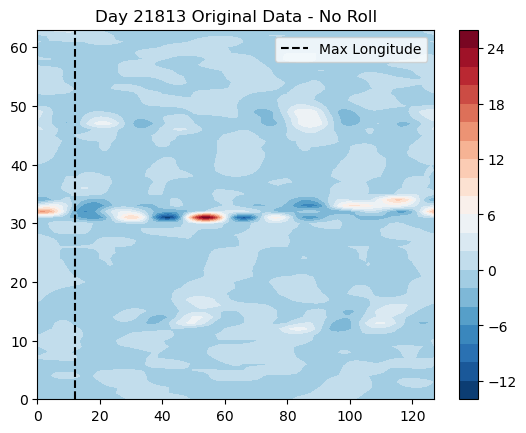

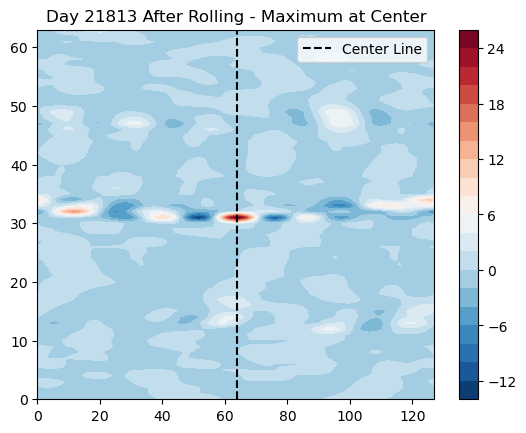

In [96]:
# Checking the rolling results
# Randomly choose a day from the positive indices to visualize
day_random = random.randint(0, positive_length - 1)
tropic_u_mean = (prec_anamol_ifft[i, :, :]).mean(axis=0) #+ z_anamol_ifft[i, 29-9:29, :]).mean(axis=0)  # Example: Tropic slice at latitude index 2

max_idx_pos = np.argmax(tropic_u_mean)

# Plot the original data (before rolling)
plt.figure()
plt.contourf(prec_anamol_ifft[day_random], levels=20, cmap='RdBu_r')
plt.colorbar()
plt.title(f"Day {day_random} Original Data - No Roll")
plt.vlines(x=max_idx_pos, ymin=0, ymax=63, color='black', linestyle='--', label='Max Longitude')
plt.legend()
plt.show()

# Plot the rolled data
plt.figure()
plt.contourf(prec_rolled_pos_test[day_random], levels=20, cmap='RdBu_r')
plt.colorbar()
plt.title(f"Day {day_random} After Rolling - Maximum at Center")
plt.vlines(x=vor_anamol_rolled_pos_test.shape[2] // 2, ymin=0, ymax=63, color='black', linestyle='--', label='Center Line')
plt.legend()
plt.show()


In [97]:
u_wind = u_rolled_pos_test[:, :, :].mean(axis=0)
v_wind = v_rolled_pos_test[:, :, :].mean(axis=0)

u_test, v_test = compute_uv_from_vorticity(vor_anamol_rolled_pos_test, xxx[1] - xxx[0], yyy[1] - yyy[0])

print(v_rolled_pos_test.shape)
v_wind.max()
print(p_rolled_pos_test.mean(axis=0).min())
print(u_wind.max())

/tmp/ipykernel_245184/1636808999.py:29: RuntimeWarning: divide by zero encountered in divide
  laplacian_inv = -1.0 / (kx**2 + ky**2)


(78000, 64, 128)
-157.83015443563775
4.607000059324415


In [85]:
div_final_eq = div_anamol_rolled_pos_test[:,26:38,:].mean(axis=0)
print(div_final_eq.min(), div_final_eq.max())
# div_anamol_rolled_pos_test.mean(axis=0).min()

-1.3566319007586041e-06 1.403947335545325e-06


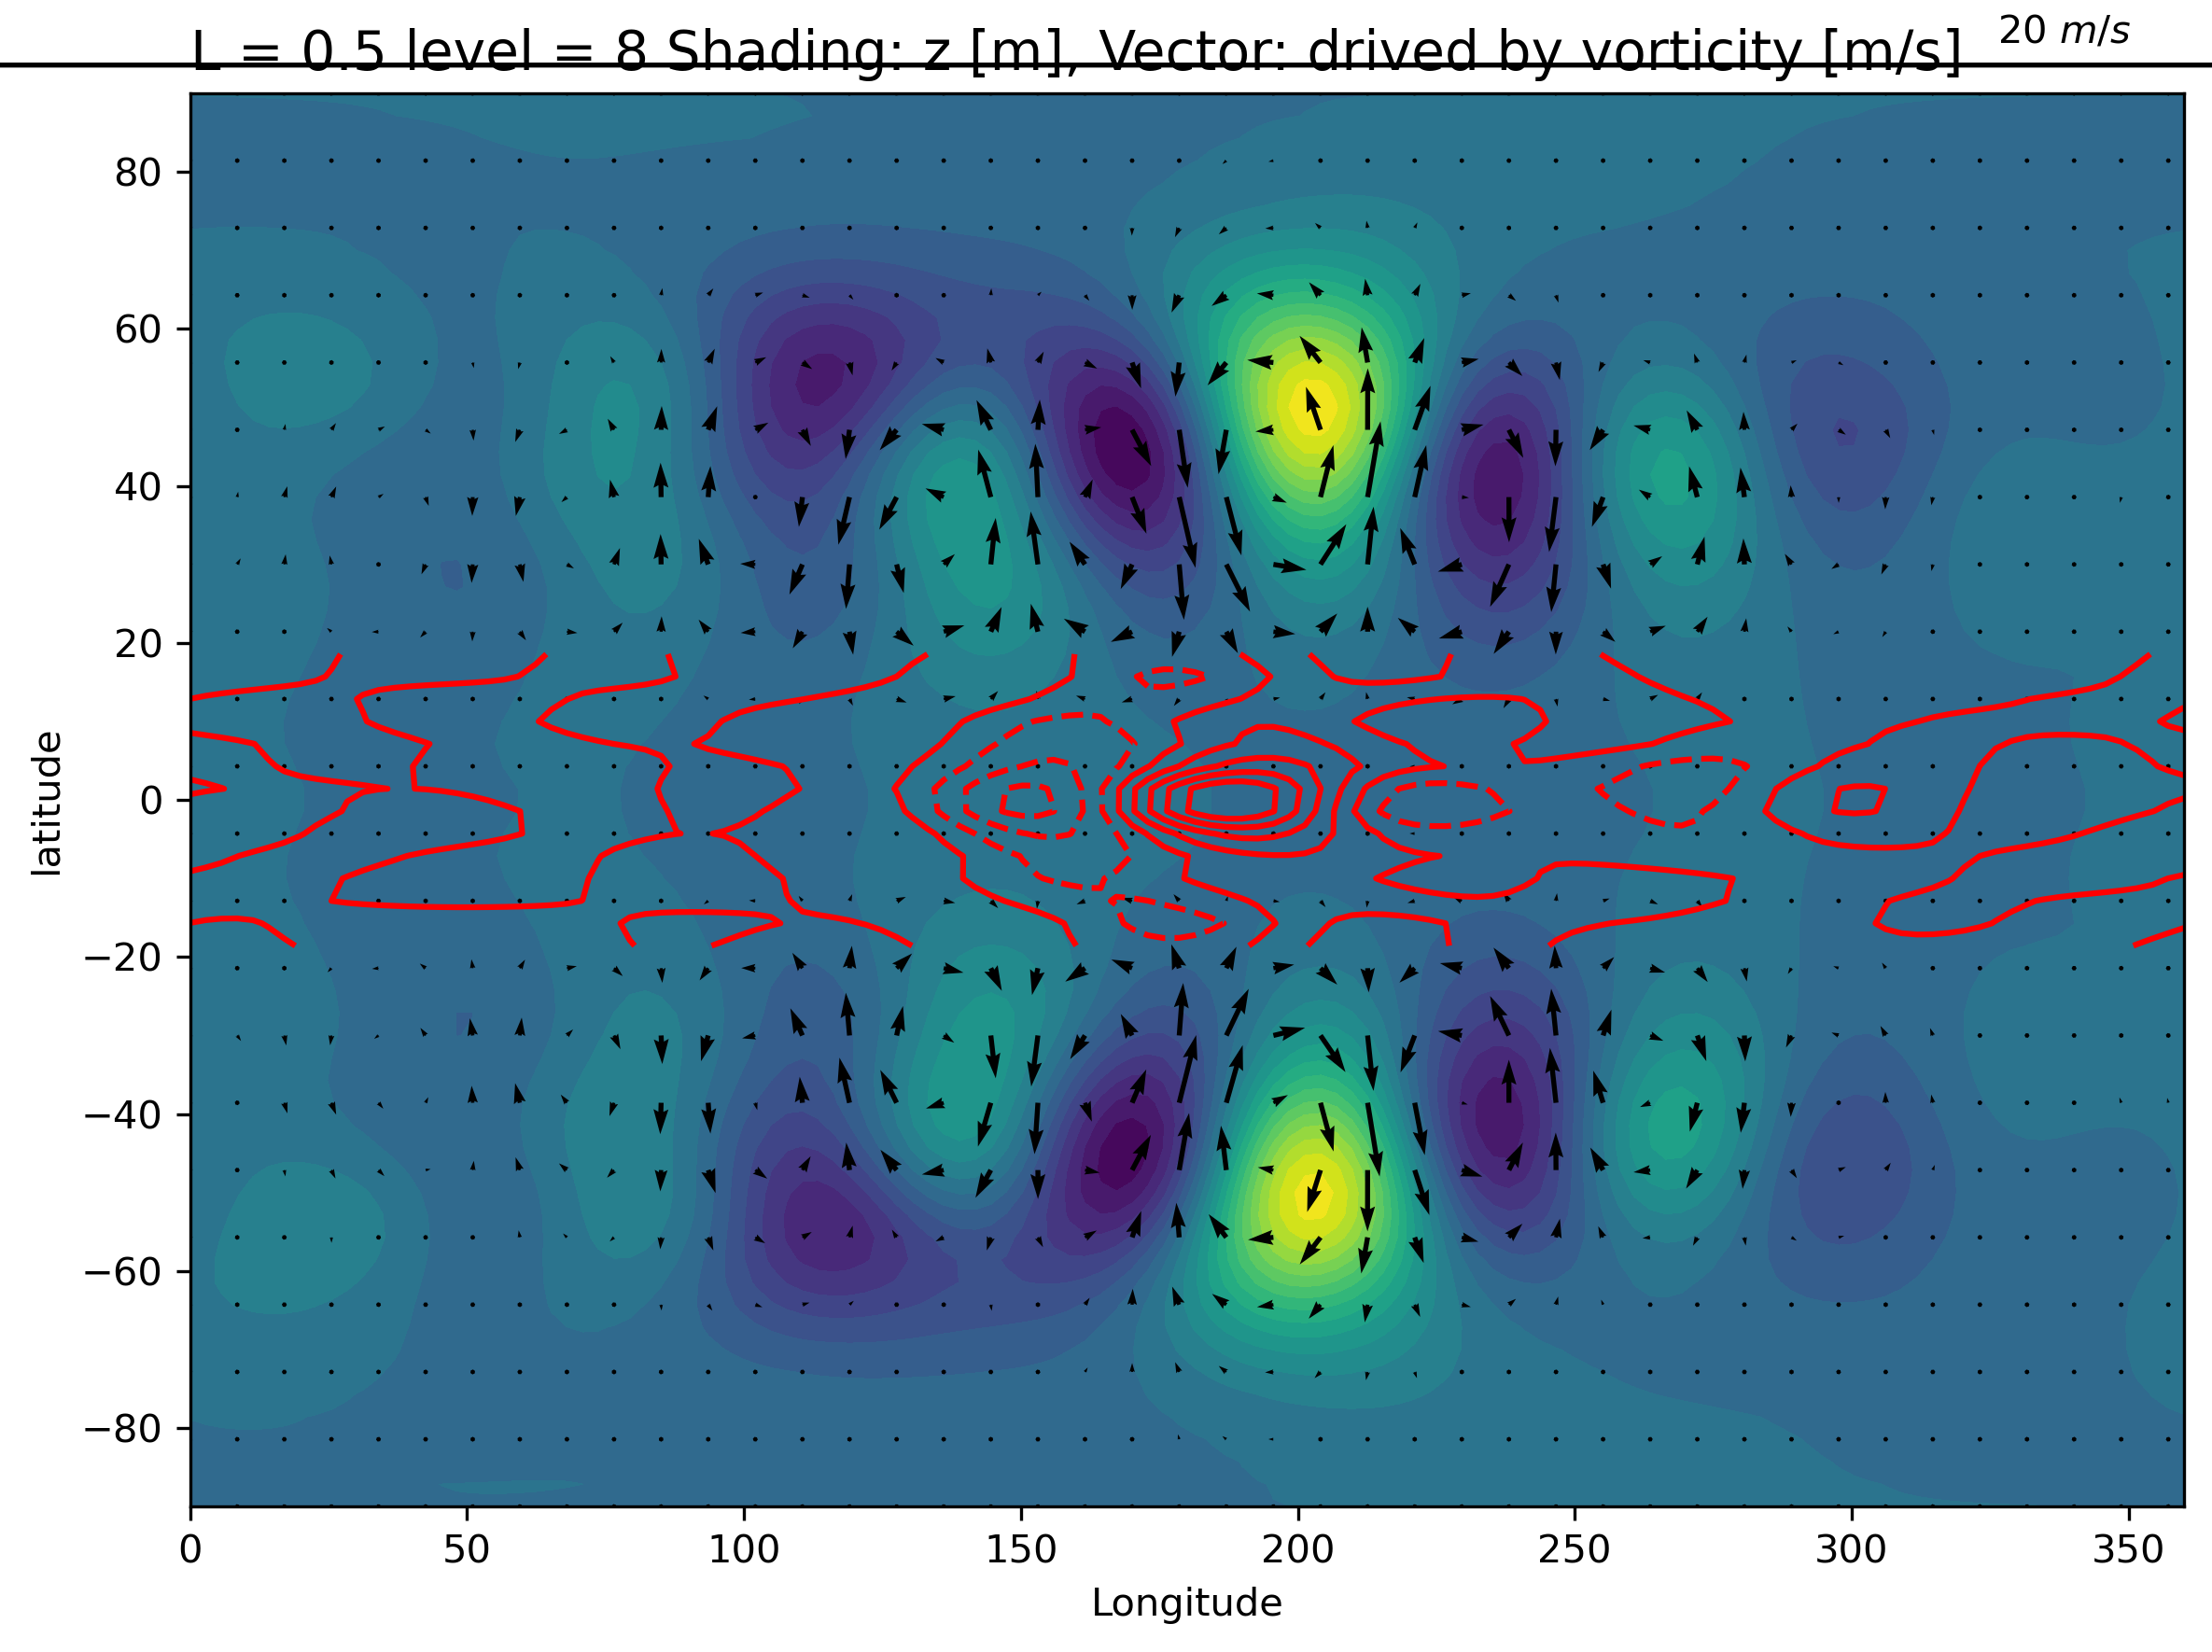

In [98]:
# Final plot
idx = 3
plt.figure(figsize=(8,6), dpi=300.)
# plt.contour(xxx2,yyy2, z_rolled_pos_test.mean(axis=0), levels=np.linspace(z_rolled_pos_test.mean(axis=0).min(), z_rolled_pos_test.mean(axis=0).max(), 11), colors="Red")
# plt.contour(xxx2[26:38,:], yyy2[26:38,:], div_anamol_rolled_pos_test.mean(axis=0)[26:38,:], levels=np.linspace(div_final_eq.min(), div_final_eq.max(), 11), colors="Red")

CS = plt.contourf(xxx2,yyy2, p_rolled_pos_test.mean(axis=0), levels=21)
plt.contour(xxx2[25:39],yyy2[25:39], div_anamol_rolled_pos_test.mean(axis=0)[25:39], levels=11, colors="Red")

# CS = plt.contourf(xxx2,yyy2, prec_rolled_pos_test.mean(axis=0), levels=21)


# plt.colorbar(CS)

# plt.contourf(xxx2,yyy2, vor_anamol_rolled_pos_test.mean(axis=0), levels=np.linspace(vor_anamol_rolled_pos_test.mean(axis=0).min(), vor_anamol_rolled_pos_test.mean(axis=0).max(), 11))

# plt.quiver(xxx2[::idx, ::idx], yyy2[::idx, ::idx], u_wind[::idx, ::idx], v_wind[::idx, ::idx], color="black", scale_units='xy', angles='xy', width=0.0025, scale=0.05)
# plt.quiver(xxx2[::idx, ::idx], yyy2[::idx, ::idx], u_test[:, ::idx, ::idx].mean(axis=0), v_test[:,::idx, ::idx].mean(axis=0), color="black", scale_units='xy', angles='xy', width=0.0025, scale=0.0000025)
wind_plt = plt.quiver(xxx2[::idx, ::idx], yyy2[::idx, ::idx], u_test[:, ::idx, ::idx].mean(axis=0), v_test[:,::idx, ::idx].mean(axis=0), color="black", scale_units='xy', angles='xy', width=0.0025, scale=0.00001)
plt.quiverkey(wind_plt,0.94,1.02, 20 ,r'20 $m/s$',labelpos='N', labelsep =0.05, color='black') # for level 5

### for level 0 ###

# wind_plt = plt.quiver(xxx2[::idx, ::idx], yyy2[::idx, ::idx], u_test[:, ::idx, ::idx].mean(axis=0), v_test[:,::idx, ::idx].mean(axis=0), color="black", scale_units='xy', angles='xy', width=0.0025, scale=0.0000014)
# plt.quiverkey(wind_plt,0.94,1.02, 20 * 0.0000014,r'20 $m/s$',labelpos='N', labelsep =0.05, color='black') # for level 0
###################

# plt.ylim([-50,50])
# plt.title(f"L = Dry Contour: div (only tropic)\n" + "Shading: z, Vector: drived by vorticity", loc="left")
plt.title(f"L = 0.5 level = {level_index} " + "Shading: z [m], Vector: drived by vorticity [m/s]", loc="left", fontsize=14)
plt.xlabel("Longitude", fontsize=10)
plt.ylabel("latitude", fontsize=10)
plt.tight_layout()
# plt.savefig("/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/PowerSpec_Dycore/image/Gill_response/pr10_without_CB.png", bbox_inches='tight', dpi=600.)
plt.show()



In [19]:
# wind_plt = plt.quiver(xxx2[::idx, ::idx], yyy2[::idx, ::idx], u_test[:, ::idx, ::idx].mean(axis=0), v_test[:,::idx, ::idx].mean(axis=0), color="black", scale_units='xy', angles='xy', width=0.0025, scale=0.0000014)
u_50 = u_test
v_50 = v_test
# CS = plt.contourf(xxx2,yyy2, z_rolled_pos_test.mean(axis=0), levels=21)
z_rolled_pos_50 = z_rolled_pos_test

Text(0.0, 1.0, 'L = 0.5 Day 47565th: Contour: z, Shading: p')

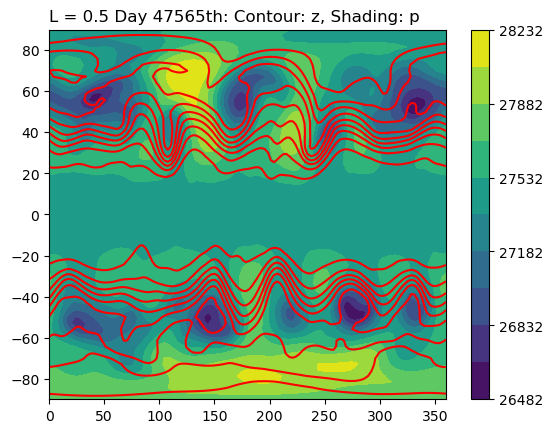

In [20]:
day_random =  random.randint(0, 78000 - 1)
plt.figure()
CS = plt.contourf(xxx2, yyy2, p[day_random], levels=np.linspace(p[day_random].min(), p[day_random].max(), 11))
plt.colorbar(CS)

plt.contour(xxx2, yyy2, z[day_random], levels=np.linspace(z[day_random].min(), z[day_random].max(), 11), colors="Red")
# plt.quiver(xxx2[::idx, ::idx], yyy2[::idx, ::idx], u_rolled_pos_test[day_random,::idx, ::idx], v_rolled_pos_test[day_random, ::idx, ::idx], color="black", scale_units='xy', angles='xy', width=0.0025, scale=0.45)

# plt.contourf(xxx2, yyy2, u_rolled_pos_test[:].mean(axis=0), levels=11)
plt.title(f"L = 0.5 Day {day_random}th: " + "Contour: z, Shading: p", loc="left")

In [ ]:
u_anamol_ifft.shape

In [16]:
import numpy as np
from scipy.fftpack import fft2, ifft2
from scipy.ndimage import laplace

def compute_uv_from_vorticity(vorticity, dx, dy):
    """
    Calculate u and v wind components from the vorticity field using streamfunction.
    
    Parameters:
    vorticity : numpy array
        2D vorticity field (time, y, x)
    dx : float
        Grid spacing in the x-direction
    dy : float
        Grid spacing in the y-direction

    Returns:
    u, v : tuple of numpy arrays
        Zonal (u) and meridional (v) wind components
    """
    # Calculate the streamfunction by inverting the Laplacian
    psi = np.zeros_like(vorticity)
    
    for t in range(vorticity.shape[0]):
        # Invert Laplacian using Fourier transforms
        kx = np.fft.fftfreq(vorticity.shape[2], dx) * 2 * np.pi
        ky = np.fft.fftfreq(vorticity.shape[1], dy) * 2 * np.pi
        kx, ky = np.meshgrid(kx, ky)
        laplacian_inv = -1.0 / (kx**2 + ky**2)
        laplacian_inv[0, 0] = 0  # To handle the division by zero at kx=ky=0

        vorticity_fft = fft2(vorticity[t, :, :])
        psi_fft = vorticity_fft * laplacian_inv
        psi[t, :, :] = np.real(ifft2(psi_fft))

    # Calculate wind components
    u = np.gradient(psi, axis=1) / dy  # Zonal wind (u)
    v = -np.gradient(psi, axis=2) / dx  # Meridional wind (v)

    return u, v


In [ ]:
v_test.min()

In [ ]:
z.shape

In [322]:
PR= 0 
theta_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/theta/PR{PR}_500_20000day_6hourly_theta_zonal_mean.dat"
# back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR0/theta/PR0_500_20000day_6hourly_theta_zonal_mean.dat


PR= 50 
theta_path_50 = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/theta/PR{PR}_500_20000day_6hourly_theta_zonal_mean.dat"
# back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR0/theta/PR0_500_20000day_6hourly_theta_zonal_mean.dat

In [323]:
with h5py.File(theta_path, "r") as f:
    theta = f["theta"][:, :, :]

with h5py.File(theta_path_50, "r") as f:
    theta_50 = f["theta"][:, :, :]


In [324]:
theta_mean = theta.mean(axis=0)
theta_50_mean = theta_50.mean(axis=0)


In [359]:
dthetady = np.zeros(theta.shape)
for i in range(1, 64-1):
    dthetady[:,:,i] = (theta[:,:,i+1] - theta[:,:,i-1]) / (np.deg2rad(y[i+1]) - np.deg2rad(y[i-1]))
dthetady[:,:,0] = (theta[:,:,1] - theta[:,:,0]) / (np.deg2rad(y[1]) - np.deg2rad(y[0]))
dthetady[:,:,-1] = (theta[:,:,-1] - theta[:,:,-2]) / (np.deg2rad(y[-1]) - np.deg2rad(y[-2]))

dthetady_mean = np.mean(dthetady,axis=0)

In [361]:
dthetady_50 = np.zeros(theta.shape)
for i in range(1, 64-1):
    dthetady_50[:,:,i] = (theta_50[:,:,i+1] - theta_50[:,:,i-1]) / (np.deg2rad(y[i+1]) - np.deg2rad(y[i-1]))
dthetady_50[:,:,0] = (theta_50[:,:,1] - theta_50[:,:,0]) / (np.deg2rad(y[1]) - np.deg2rad(y[0]))
dthetady_50[:,:,-1] = (theta_50[:,:,-1] - theta_50[:,:,-2]) / (np.deg2rad(y[-1]) - np.deg2rad(y[-2]))

dthetady_50_mean = np.mean(dthetady_50,axis=0)

-90.84318031746302 91.65071644633855
-109.51332532892472 108.53152470226777


(1.0, 0.0)

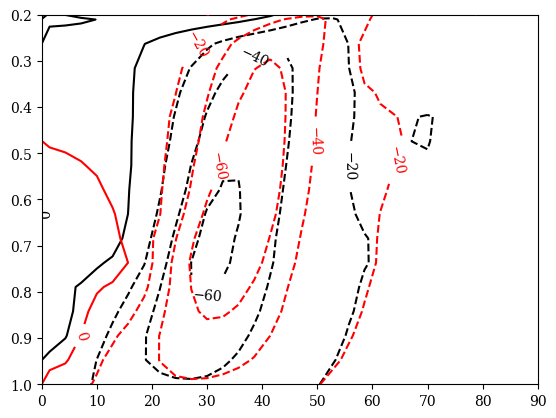

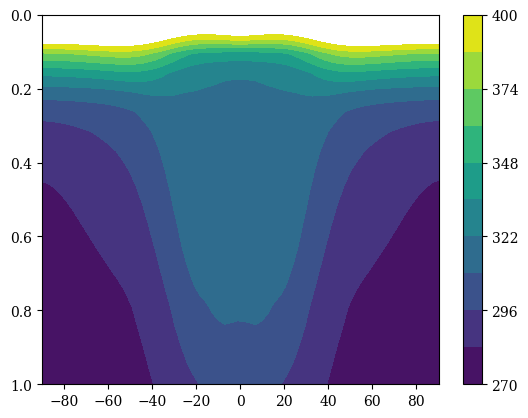

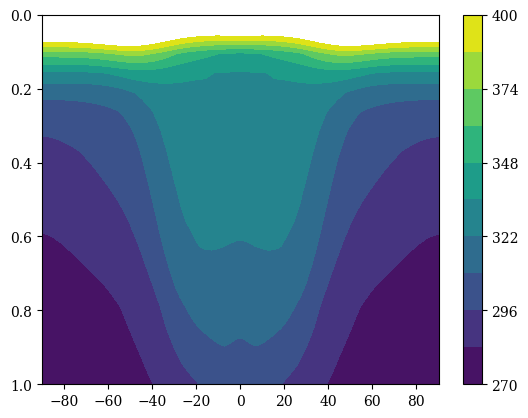

In [372]:
sigma_onlyz = np.linspace(0,1,20)
y = np.linspace(-90,90,64)

yy, sigma = np.meshgrid(y, sigma_onlyz)


plt.figure()
CS1 = plt.contour(yy, sigma, dthetady_mean, colors="Black",levels=np.linspace(-100,100,11))
CS2 = plt.contour(yy, sigma, dthetady_50_mean, colors="Red",levels=np.linspace(-100,100,11))
print(dthetady_mean.min(), dthetady_mean.max())
print(dthetady_50_mean.min(), dthetady_50_mean.max())

# CS2 = plt.contour(yy, sigma, theta_mean - theta_50_mean, colors="Red",levels=11)


plt.clabel(CS1)
plt.clabel(CS2)

plt.ylim([1,0.2])
plt.xlim([0,90])


plt.figure()
CS1 = plt.contourf(yy, sigma, theta_mean,levels=np.linspace(270,400,11))
plt.ylim([1,0])
plt.colorbar()

plt.figure()
CS2 = plt.contourf(yy, sigma, theta_50_mean,levels=np.linspace(270,400,11))
plt.colorbar()
plt.ylim([1,0])


In [58]:
(p).mean()

27516.13

In [605]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Rolling the maximum value data to the center of the longitude
# then, the other datas do the same amount for rolling

# Assuming 'positive' is the array of indices where vor_anamol_ifft_time_normal > 2
positive_length = 78000 #np.shape(positive[0, :])[0]

prec_rolled_pos_test = np.zeros((positive_length, 64, 128))  # Example: 6 latitudes, 128 longitudes


# level_idx = 0
# Loop over positive indices
for i in range(positive_length):
    # tropic_u_mean = (z_anamol_ifft[i, 35:35+9, :] + z_anamol_ifft[i, 29-9:29, :]).mean(axis=0)  # Example: Tropic slice at latitude index 2
    # tropic_u_mean = (prec_recon[i, :, :] ).mean(axis=0) #+ z_anamol_ifft[i, 29-9:29, :]).mean(axis=0)  # Example: Tropic slice at latitude index 2
    tropic_u_mean = (prec_anamol_ifft[i, :, :] ).mean(axis=0) #+ z_anamol_ifft[i, 29-9:29, :]).mean(axis=0)  # Example: Tropic slice at latitude index 2


    # Example: Tropic slice at latitude index 2
    for j in range(64):  # Loop over the latitude dimension (6 latitudes)
        # Extract the vorticity slice for each time step at index 'i' and latitude 'j'
        
        # Find the x index of the maximum value in the tropic region
        max_idx_pos = np.argmax(tropic_u_mean)
        
        
        # Calculate the roll amount to center the max value on the x-axis
        roll_amount_pos = (vor_anamol_rolled_pos_test.shape[2] // 2) - max_idx_pos
        

        prec_rolled_pos_test[i, j, :]          = np.roll(prec_anamol_ifft[i, j, :], roll_amount_pos)

        

Text(0.5, 1.0, 'Rolling Prec')

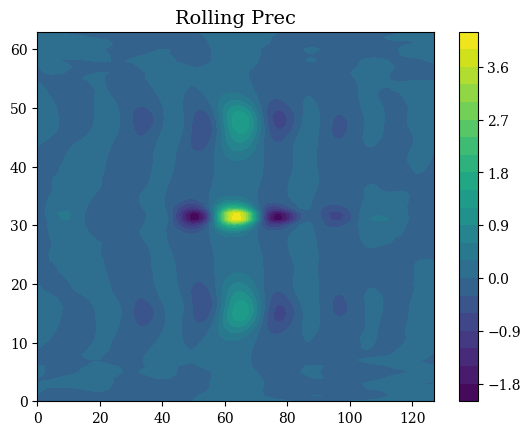

In [606]:
plt.figure()
CS = plt.contourf(prec_rolled_pos_test.mean(axis=0), levels=21)
plt.colorbar(CS)
plt.title("Rolling Prec")

In [220]:
# level_index = 5

# with h5py.File(p_path, "r") as f_p:
#     p = f_p["p"][:, level_index, :, :]
p.mean()

67535.055